# **Project 1. Autoencoders**

##### **Students**: 
#### Mario Coronado Fernández - 100496637
#### Jorge Chamorro Pedrosa - 100496527

### Import Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from torchvision import datasets, transforms
import copy
import random

### Create the Autoencoder Class

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, dimx: int, hidden_dims: list, projected: int):
        """
        dimx: Input dimension
        hidden_dims: List of hidden layer sizes (can be of length 2 or 4 for 3-layer or 5-layer models)
        projected: Size of the latent dimension
        """
        super().__init__()

        # Encoder construction
        encoder_layers = []
        prev_dim = dimx
        for h in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h))
            encoder_layers.append(nn.LeakyReLU(0.1))  # Non-linearity
            prev_dim = h
        encoder_layers.append(nn.Linear(prev_dim, projected))
        encoder_layers.append(nn.LeakyReLU(0.1))  # Activation

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder construction (reverse order of encoder)
        decoder_layers = []
        prev_dim = projected
        for h in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h))
            decoder_layers.append(nn.LeakyReLU(0.1))
            prev_dim = h
        decoder_layers.append(nn.Linear(prev_dim, dimx))
        decoder_layers.append(nn.Tanh())  # Output activation. We use as activation of the last neuron hyperbolic tangent 
                                          # in order to be able to compare the last output with original data. The later takes values between [-1,1]

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        latent = self.encoder(x)
        decoded = self.decoder(latent)
        return decoded



Autoencoder Extension to perform training, compute losses, etc.

In [3]:
class AutoencoderExtended(Autoencoder):
    def __init__(self, dimx, hidden_dims, projected, epochs=30, lr=0.01):
        super().__init__(dimx, hidden_dims, projected)
        self.lr = lr
        self.epochs = epochs
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.criterion = nn.MSELoss()

        # Track training and validation losses during training
        self.loss_during_training = []
        self.valid_loss_during_training = []
    
    def trainloop(self, trainloader, validloader):
        """
        Train the autoencoder and track loss. 
        trainloader: PyTorch DataLoader object for training data.
        validloader: PyTorch DataLoader object for validation data.
        """
        
        for e in range(self.epochs):
            running_loss = 0.
            for (inputs, _ ) in trainloader:
                # Reshape inputs to flatten dimensions for the model
                inputs = inputs.reshape(inputs.shape[0],-1)
                # Get model reconstructions
                out = self.forward(inputs)
                # Calculate loss (reconstruction error)
                loss = self.criterion(out, inputs)
                # Track average training loss per epoch
                running_loss += loss.item()

                # Update model weights
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
            
            # Track average training loss per epoch
            self.loss_during_training.append(running_loss/len(trainloader))

            # Validation loop (evaluate model on validation data)
            with torch.no_grad():  # Disable gradients for validation
                running_loss = 0.
                for (inputs, _) in validloader:
                    inputs = inputs.reshape(inputs.shape[0],-1)
                    out = self.forward(inputs)
                    loss = self.criterion(out, inputs)
                    running_loss += loss.item()

                # Calculate average validation loss for the epoch
                self.valid_loss_during_training.append(running_loss/len(validloader))

            if(e % 1 == 0):
                print(f'Epoch {e}. Training loss: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}')


    def testloop(self, dataloader):
        """
        Compute reconstruction error on a given dataset (test).
        dataloader: PyTorch DataLoader object for the test dataset.
        """
        total_loss = 0.0
        n = 0
        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.view(inputs.shape[0], -1)
                out = self.forward(inputs)
                batch_loss = self.criterion(out, inputs).item()
                
                total_loss += batch_loss * inputs.size(0)  # Weighted sum
                n += inputs.size(0)

        avg_loss = total_loss/n
        print(f'Mean reconstruction loss: {avg_loss:.6f}')
        return avg_loss


    def plot_reconstructions(self, dataloader, num_images=5):
        """
        Plot original and reconstructed images.
        dataloader: PyTorch DataLoader object for the test dataset.
        num_images: Number of image pairs (original and reconstructed) to display show.
        """
        inputs, _ = next(iter(dataloader))  # Select a batch
        inputs = inputs[:num_images]  # Select subset
        inputs_flat = inputs.view(inputs.shape[0], -1)
        
        with torch.no_grad():
            reconstructed = self.forward(inputs_flat).view(inputs.shape)  # Reshape back to image format

        fig, axes = plt.subplots(2, num_images, figsize=(num_images * 1.5, 3))
        
        for i in range(num_images):
            axes[0, i].imshow(inputs[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')

        axes[0, 0].set_title("Originals", fontsize=12)
        axes[1, 0].set_title("Reconstructed", fontsize=12)
        plt.show()

## **Influence of the projected dimension (15,30,50,100)**

### MNIST dataset

In [4]:
from torch.utils.data import Subset


transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),]) # which scales the image values to [-1,1].
                              
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

# Create samples to train faster
train_subset_indices = list(range(10000))               # 10k images for training
valid_subset_indices = list(range(10000, 15000))       # 5k images for validation

train_subset = Subset(trainset, train_subset_indices)
valid_subset = Subset(trainset, valid_subset_indices)


# New dataloaders
trainloader_subset = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
validloader_subset = torch.utils.data.DataLoader(valid_subset, batch_size=64, shuffle=True)



torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


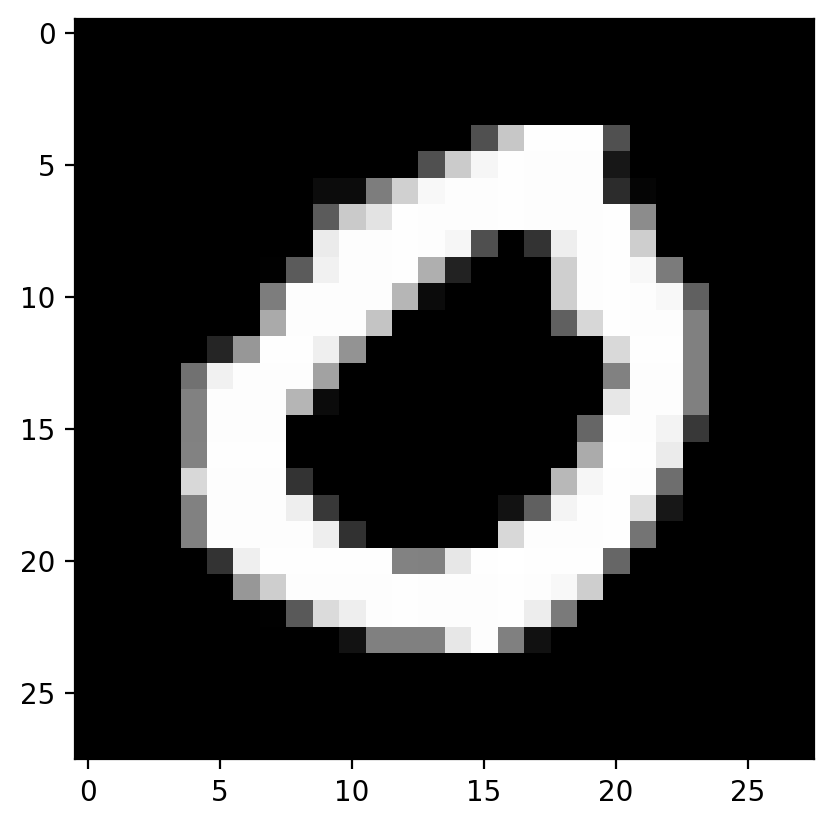

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

### Best Architecture for each Layer 

In [7]:
import torch
import random

# Define search space
three_layer_sizes = [512, 256, 128, 64]
five_layer_sizes = [512, 256, 128, 64, 32]
projected_dims = [15, 30, 50, 100]

# Store results
three_layer_options = []
five_layer_options = []

# Generate valid configurations for 3-layer autoencoder
for X in three_layer_sizes:
    for Y in three_layer_sizes:
        if X > Y:
            three_layer_options.append((X, Y))

# Generate valid configurations for 5-layer autoencoder
for A in five_layer_sizes:
    for B in five_layer_sizes:
        if A > B:
            for C in five_layer_sizes:
                if B > C:
                    for D in five_layer_sizes:
                        if C > D:
                            five_layer_options.append((A, B, C, D))

# Store results for different projections
results_train = {}
results_valid = {}

# Training loop for 3-layers
for config in random.sample(three_layer_options, 3):  # Select 3 random configurations
    for proj_dim in projected_dims:
        print(f"\n Training 3-layer Autoencoder | Hidden: {config} | Projected Dim: {proj_dim}")
        autoencoder = AutoencoderExtended(dimx=784, hidden_dims=config, projected=proj_dim, epochs=10, lr=0.001)
        autoencoder.trainloop(trainloader_subset, validloader_subset)
        results_train[('3-layer', config, proj_dim)] = autoencoder.loss_during_training
        results_valid[('3-layer', config, proj_dim)] = autoencoder.valid_loss_during_training

# Training loop for 5-layers
for config in random.sample(five_layer_options, 3):  # Select 3 random configurations
    for proj_dim in projected_dims:
        print(f"\nTraining 5-layer Autoencoder | Hidden: {config} | Projected Dim: {proj_dim}")
        autoencoder = AutoencoderExtended(dimx=784, hidden_dims=config, projected=proj_dim, epochs=10, lr=0.001)
        autoencoder.trainloop(trainloader_subset, validloader_subset)
        results_train[('5-layer', config, proj_dim)] = autoencoder.loss_during_training
        results_valid[('5-layer', config, proj_dim)] = autoencoder.valid_loss_during_training



 Training 3-layer Autoencoder | Hidden: (256, 64) | Projected Dim: 15
Epoch 0. Training loss: 0.25304252450253556. Validation loss: 0.16112218721757962
Epoch 1. Training loss: 0.13596194299163333. Validation loss: 0.12383130532276782
Epoch 2. Training loss: 0.10869801471567457. Validation loss: 0.10395795097456703
Epoch 3. Training loss: 0.09478181890051836. Validation loss: 0.09377522860901265
Epoch 4. Training loss: 0.08499990375178634. Validation loss: 0.08614801181645333
Epoch 5. Training loss: 0.07869801295411055. Validation loss: 0.08002123368691795
Epoch 6. Training loss: 0.07445283269711361. Validation loss: 0.07724910370911224
Epoch 7. Training loss: 0.07147450315629601. Validation loss: 0.0746803025278864
Epoch 8. Training loss: 0.0689612496288339. Validation loss: 0.07290687652516968
Epoch 9. Training loss: 0.06631760061926144. Validation loss: 0.07071055561492715

 Training 3-layer Autoencoder | Hidden: (256, 64) | Projected Dim: 30
Epoch 0. Training loss: 0.26658481264569

In [8]:
# Find the best 3-layer and 5-layer configurations based on minimum validation loss
best_3_layer = min(
    ((key, loss) for key, loss in results_valid.items() if key[0] == '3-layer'),
    key=lambda x: x[1]
)

best_5_layer = min(
    ((key, loss) for key, loss in results_valid.items() if key[0] == '5-layer'),
    key=lambda x: x[1]
)

best_3_layer, best_5_layer

((('3-layer', (512, 128), 100),
  [0.13055143486472626,
   0.08832132212723358,
   0.0711557654828965,
   0.059683180166573466,
   0.053657115920435025,
   0.05090225021107287,
   0.048091342601972294,
   0.045120500641155845,
   0.04318930213398571,
   0.040748620146437535]),
 (('5-layer', (512, 256, 128, 32), 50),
  [0.22675109286851522,
   0.18186981994894486,
   0.13315913175480276,
   0.12087242522194416,
   0.10945198892415324,
   0.09931110986803152,
   0.09538914442439622,
   0.08954467614994774,
   0.08656292182358005,
   0.08439360464675517]))

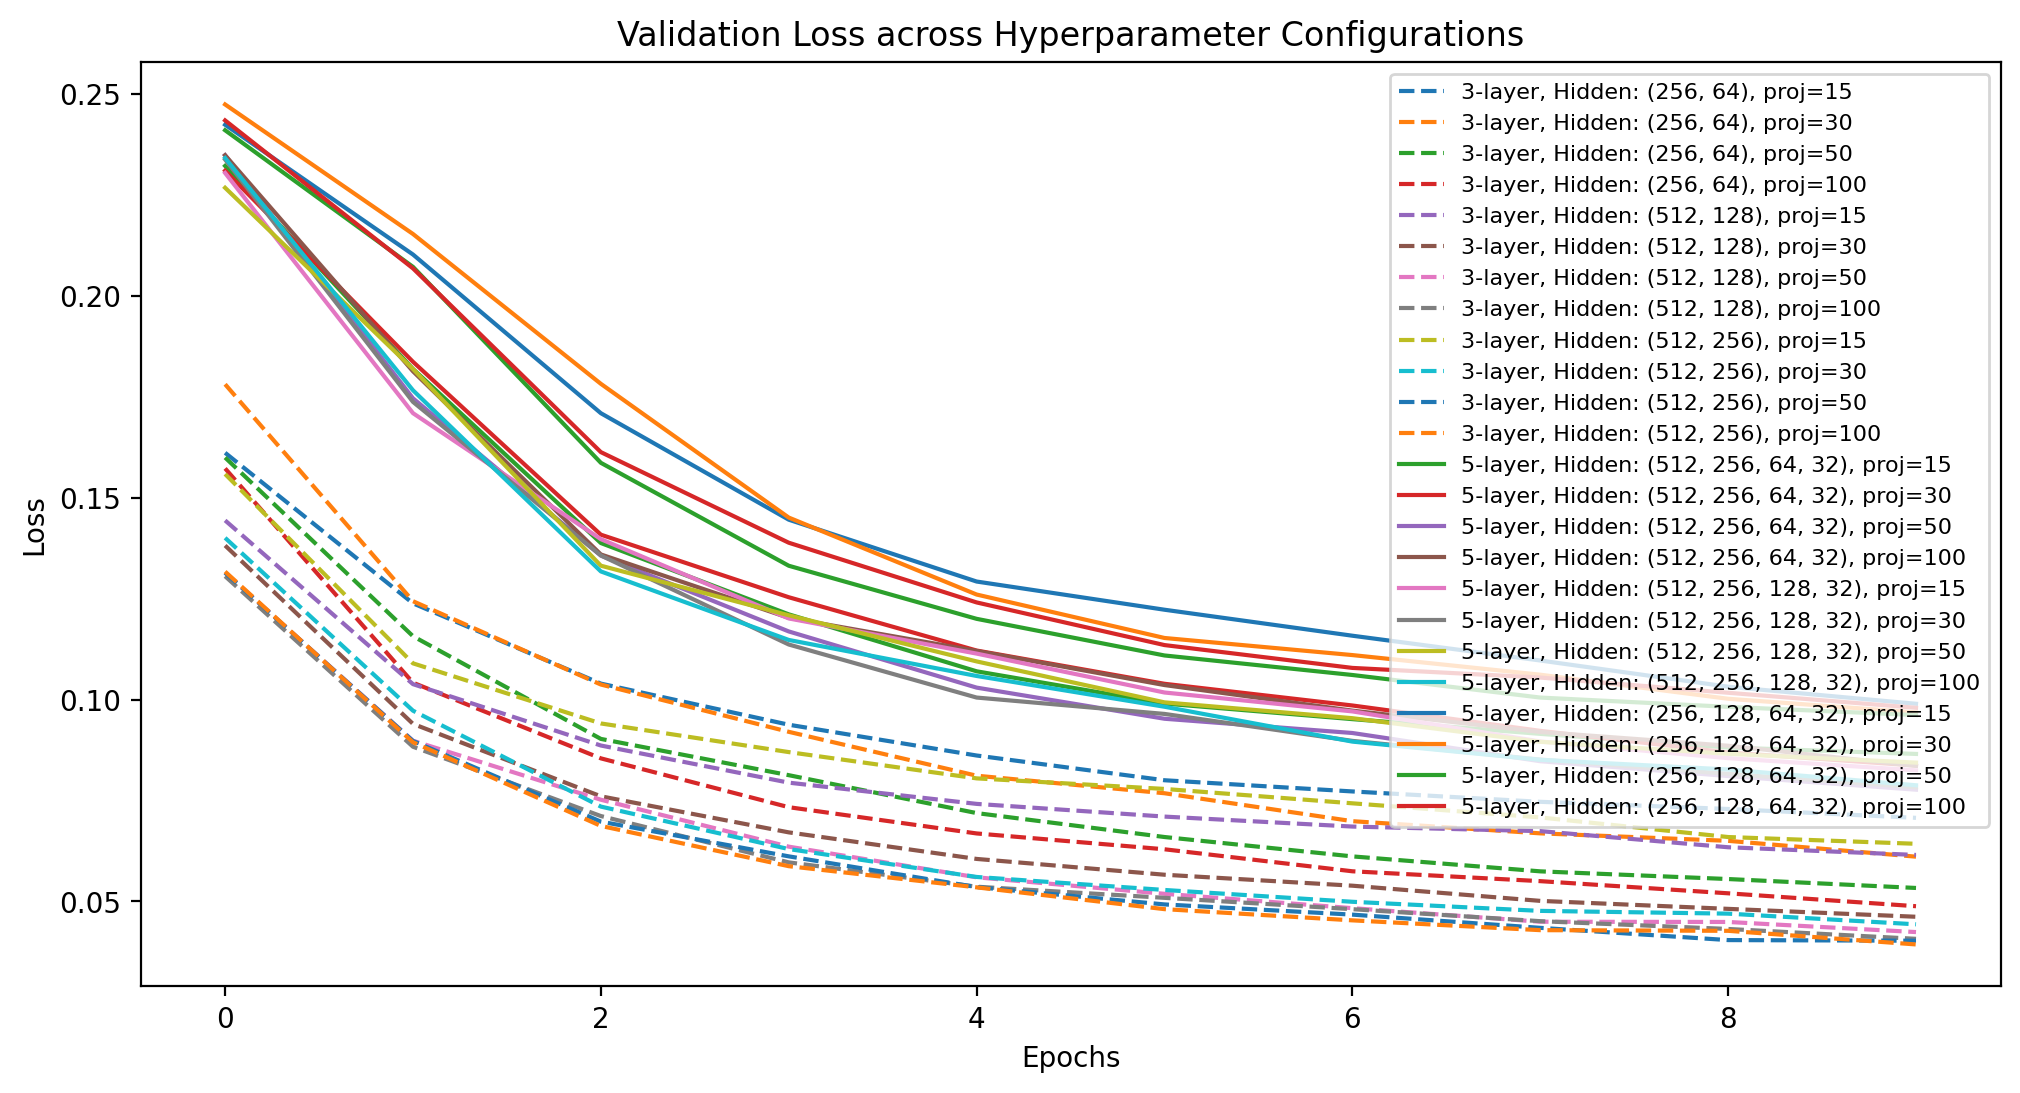

In [9]:

# Plot Loss Curve
import matplotlib.pyplot as plt

def plot_losses(results, type):
    """
    Plots the training/validation losses for different layer configurations and projection dimensions.
    results: Dictionary containing losses for different architectures, hidden layer configurations, and projected dimensions.
    title: 'Training Loss' or 'Validation Loss').
    """
    plt.figure(figsize=(12, 6))

    for (name, config, proj_dim), losses in results.items():
        if name == "3-layer":
            linestyle = '--'
        else:
            linestyle = '-'
        label = f"{name}, Hidden: {config}, proj={proj_dim}"
        plt.plot(losses, linestyle=linestyle, label=label)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(type)
    plt.legend(loc="best", fontsize=8)
    plt.show()

# Plot Validation Losses
plot_losses(results_valid, "Validation Loss across Hyperparameter Configurations")



We found the best hidden layer dimension combination to be (minimizes the MSE loss):
- 3-layer: [512, 128]
- 5-layer: [512, 256, 128, 32]

Training 3-layer autoencoder with projected dimension 15
Epoch 0. Training loss: 0.2313012860383198. Validation loss: 0.14815314359302761
Epoch 1. Training loss: 0.11729855209019534. Validation loss: 0.10325271155260786
Epoch 2. Training loss: 0.09180741349033489. Validation loss: 0.08936744805755495
Epoch 3. Training loss: 0.08134949311708949. Validation loss: 0.08329275863457329
Epoch 4. Training loss: 0.07550226109232872. Validation loss: 0.0776986088367957
Epoch 5. Training loss: 0.07105448265459127. Validation loss: 0.07578361020246639
Epoch 6. Training loss: 0.06779022063988789. Validation loss: 0.07293532967944688
Epoch 7. Training loss: 0.06519636476210727. Validation loss: 0.07142815790787528
Epoch 8. Training loss: 0.06280881714574091. Validation loss: 0.06885877723180794
Epoch 9. Training loss: 0.06066041845519831. Validation loss: 0.06771514866548249


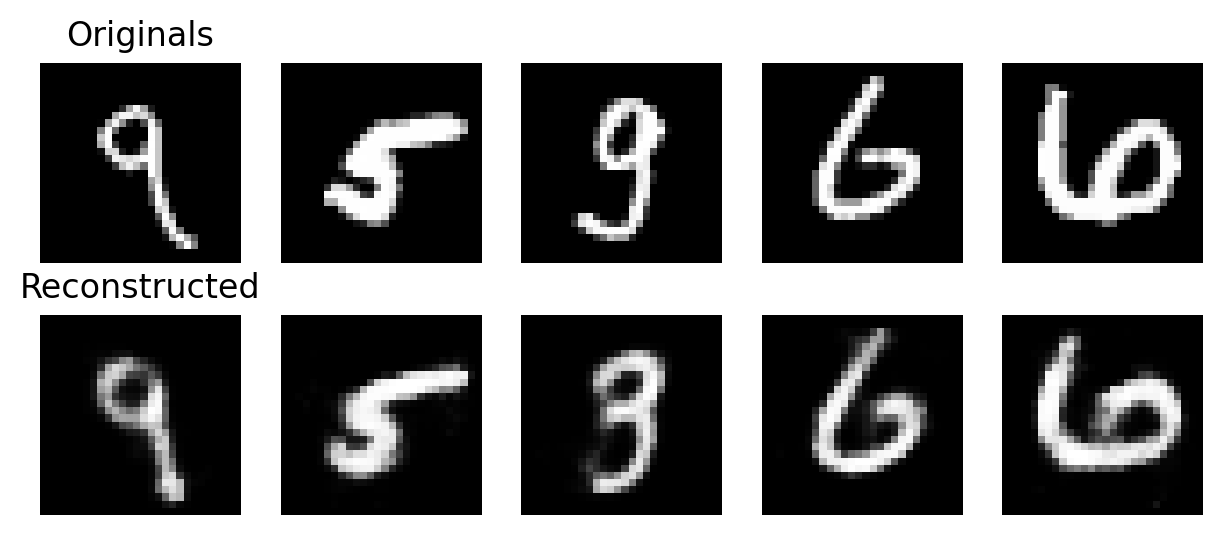

Training 3-layer autoencoder with projected dimension 30
Epoch 0. Training loss: 0.2176714133779714. Validation loss: 0.13132137701481203
Epoch 1. Training loss: 0.10477271025917333. Validation loss: 0.09182909244223486
Epoch 2. Training loss: 0.07737564091469831. Validation loss: 0.0737252403286439
Epoch 3. Training loss: 0.06441869907033672. Validation loss: 0.06251601483437079
Epoch 4. Training loss: 0.0565233912295217. Validation loss: 0.05903351750177673
Epoch 5. Training loss: 0.051497155147942765. Validation loss: 0.054746725985521
Epoch 6. Training loss: 0.04765762096852254. Validation loss: 0.04995459077667586
Epoch 7. Training loss: 0.043968842121636036. Validation loss: 0.0477059748070904
Epoch 8. Training loss: 0.04149944909438966. Validation loss: 0.04633126332412792
Epoch 9. Training loss: 0.03904596006699428. Validation loss: 0.04434892700254163


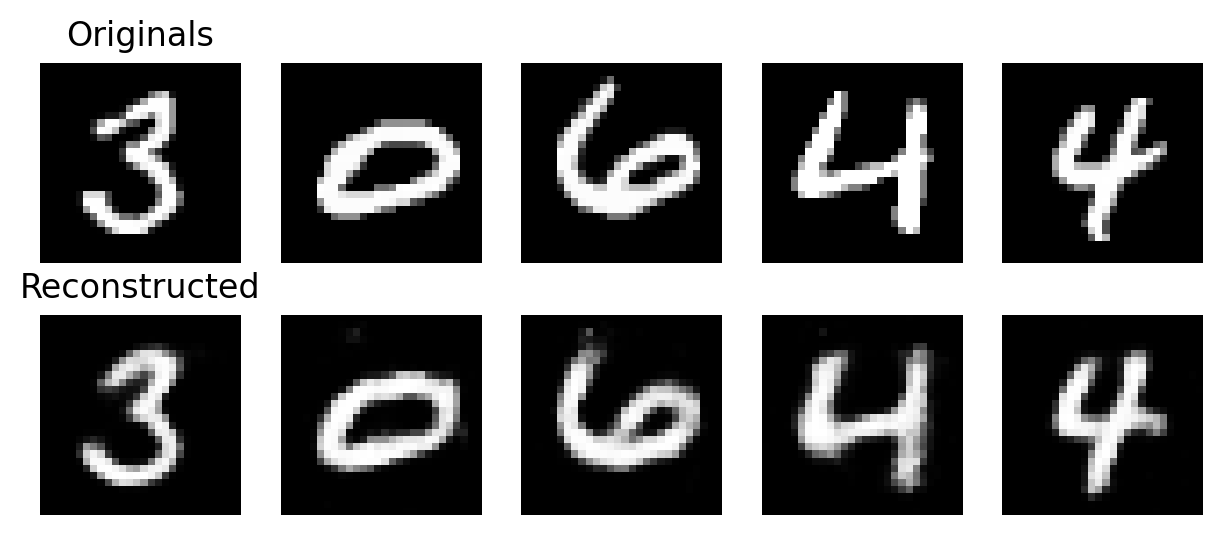

Training 3-layer autoencoder with projected dimension 50
Epoch 0. Training loss: 0.22397756215873038. Validation loss: 0.14087566657911374
Epoch 1. Training loss: 0.10880816281790946. Validation loss: 0.09481881766379634
Epoch 2. Training loss: 0.08056824839418861. Validation loss: 0.07484518613996385
Epoch 3. Training loss: 0.06566443984770472. Validation loss: 0.06352612050839618
Epoch 4. Training loss: 0.05583224663878702. Validation loss: 0.056784718002699595
Epoch 5. Training loss: 0.04942685823626579. Validation loss: 0.052328082485289515
Epoch 6. Training loss: 0.0449864863162967. Validation loss: 0.0500922013027004
Epoch 7. Training loss: 0.04163096681427045. Validation loss: 0.047761837798583354
Epoch 8. Training loss: 0.03884803760013762. Validation loss: 0.04451398084623904
Epoch 9. Training loss: 0.036462096722832155. Validation loss: 0.043463949019773095


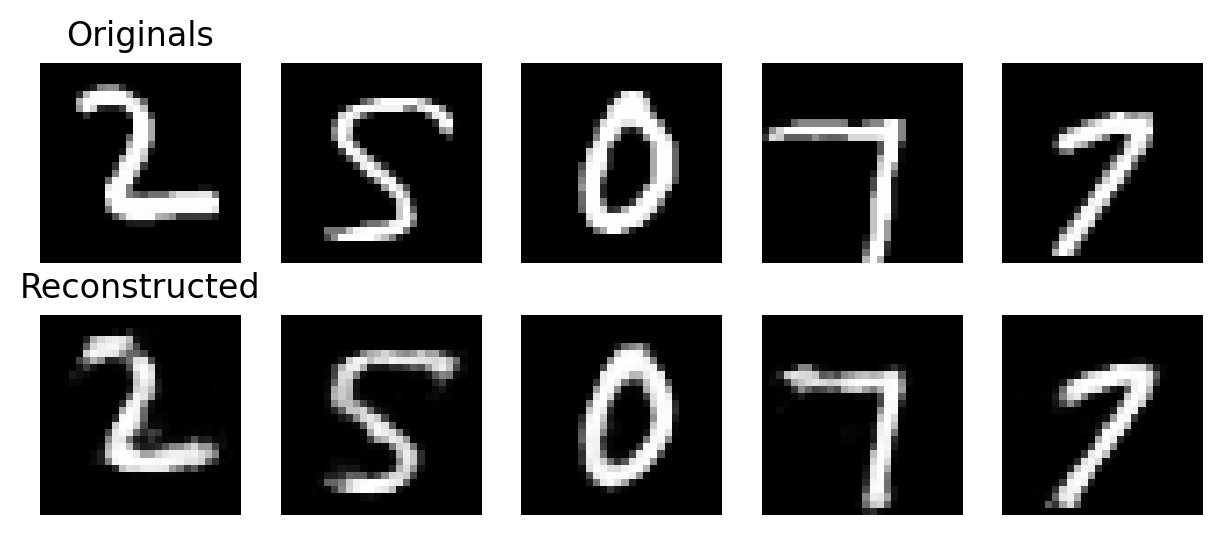

Training 3-layer autoencoder with projected dimension 100
Epoch 0. Training loss: 0.22289972676403202. Validation loss: 0.1290478522453127
Epoch 1. Training loss: 0.10122604554246185. Validation loss: 0.0853845184739632
Epoch 2. Training loss: 0.07343805296595689. Validation loss: 0.06890266398085823
Epoch 3. Training loss: 0.05927490106054172. Validation loss: 0.058147236799137504
Epoch 4. Training loss: 0.05094593974530317. Validation loss: 0.05136385772235786
Epoch 5. Training loss: 0.045215090962162446. Validation loss: 0.047320698635487615
Epoch 6. Training loss: 0.041465650911733605. Validation loss: 0.04767427126629443
Epoch 7. Training loss: 0.03842496848220279. Validation loss: 0.04228190799491315
Epoch 8. Training loss: 0.03555959073980902. Validation loss: 0.041428274699027025
Epoch 9. Training loss: 0.03360646749567834. Validation loss: 0.040720252013659176


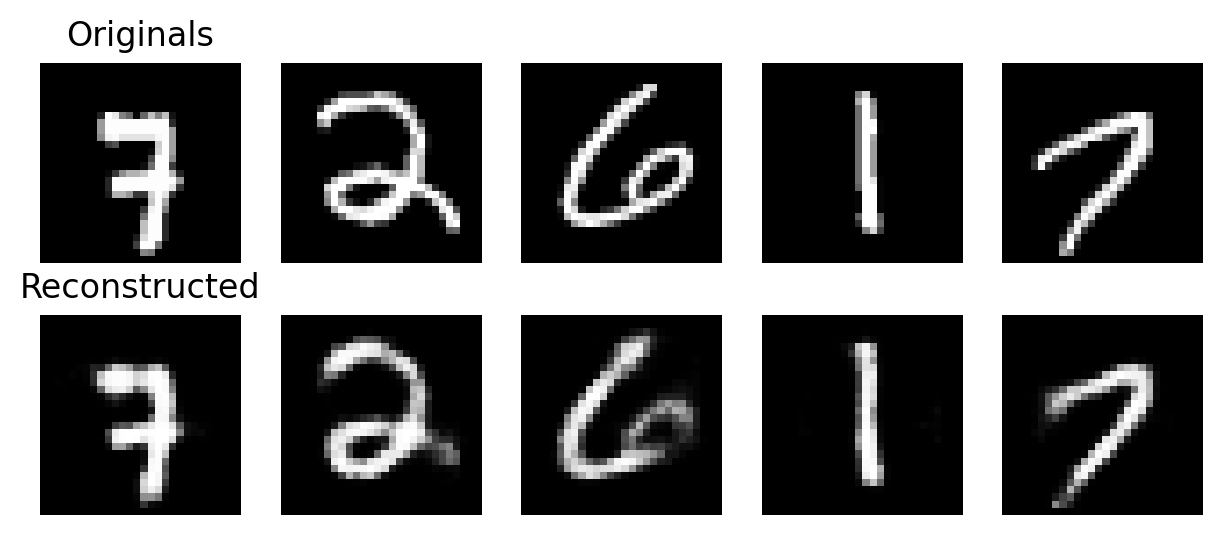

Training 5-layer autoencoder with projected dimension 15
Epoch 0. Training loss: 0.27991206023343806. Validation loss: 0.23277120876915847
Epoch 1. Training loss: 0.1961103050382274. Validation loss: 0.17845759719987458
Epoch 2. Training loss: 0.15098133322539603. Validation loss: 0.14004386376731004
Epoch 3. Training loss: 0.1258160066642579. Validation loss: 0.12356916324624533
Epoch 4. Training loss: 0.11166478740941187. Validation loss: 0.11052600162315972
Epoch 5. Training loss: 0.10224325769835976. Validation loss: 0.10543170080909246
Epoch 6. Training loss: 0.09645155053229848. Validation loss: 0.09940739183486262
Epoch 7. Training loss: 0.0921176641610018. Validation loss: 0.09811482597378236
Epoch 8. Training loss: 0.08791524261995486. Validation loss: 0.09384655792124663
Epoch 9. Training loss: 0.084739765259111. Validation loss: 0.09123119919360438


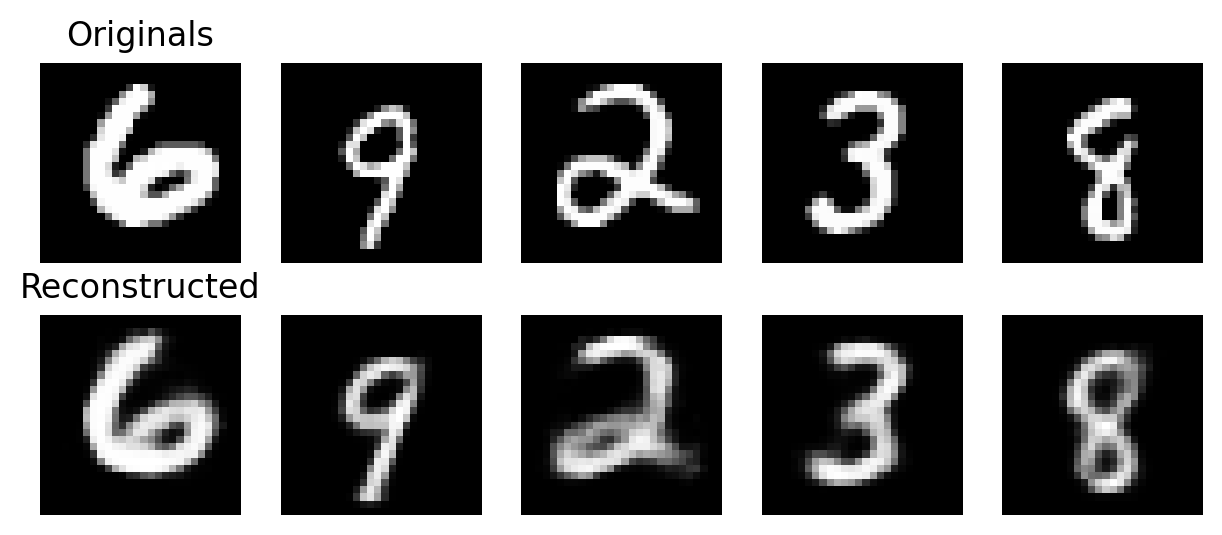

Training 5-layer autoencoder with projected dimension 30
Epoch 0. Training loss: 0.2846219575708839. Validation loss: 0.2290432117407835
Epoch 1. Training loss: 0.19891927775683677. Validation loss: 0.1864250787074053
Epoch 2. Training loss: 0.15403649263131391. Validation loss: 0.1357040895691401
Epoch 3. Training loss: 0.12182072118209426. Validation loss: 0.11891132970399494
Epoch 4. Training loss: 0.10796671412932644. Validation loss: 0.10863218626266793
Epoch 5. Training loss: 0.09819999602949543. Validation loss: 0.09905419366646416
Epoch 6. Training loss: 0.09115761831687515. Validation loss: 0.09278993016179604
Epoch 7. Training loss: 0.08578159138085736. Validation loss: 0.08927380142709877
Epoch 8. Training loss: 0.0805836510696229. Validation loss: 0.08630818571848205
Epoch 9. Training loss: 0.07651439885709696. Validation loss: 0.08137019827396055


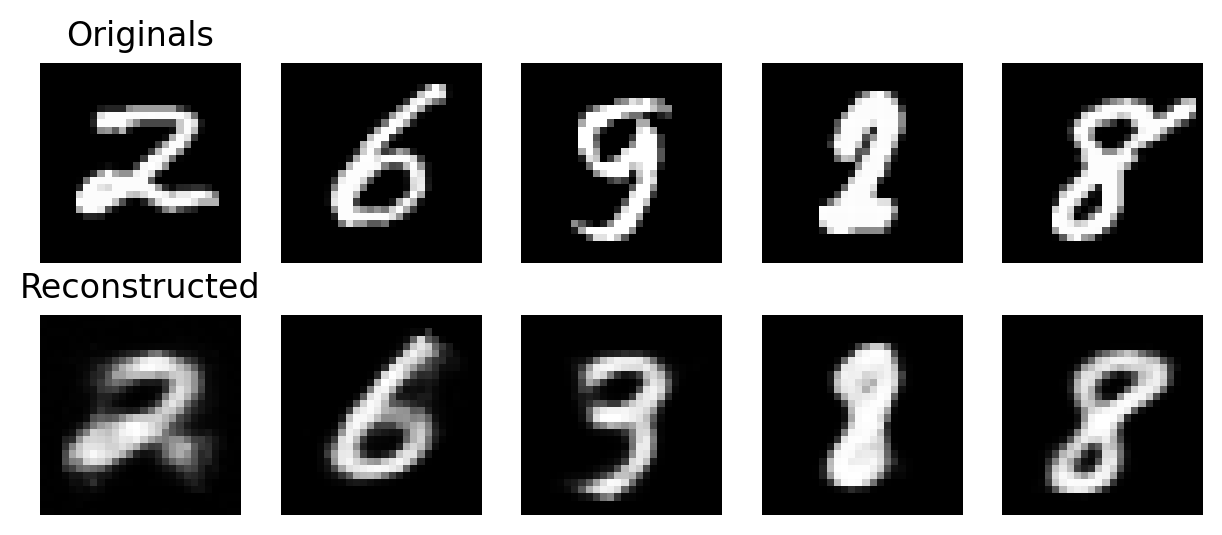

Training 5-layer autoencoder with projected dimension 50
Epoch 0. Training loss: 0.2804768480313052. Validation loss: 0.23221971811373024
Epoch 1. Training loss: 0.19849750712798658. Validation loss: 0.18049859510192387
Epoch 2. Training loss: 0.15400694025929568. Validation loss: 0.1392272368450708
Epoch 3. Training loss: 0.1243209536098371. Validation loss: 0.12097294506015657
Epoch 4. Training loss: 0.10947342990500153. Validation loss: 0.1113971900902217
Epoch 5. Training loss: 0.0973779855734983. Validation loss: 0.09789564715156072
Epoch 6. Training loss: 0.08848201056384737. Validation loss: 0.0893089549639557
Epoch 7. Training loss: 0.08191578232558669. Validation loss: 0.08530113223610045
Epoch 8. Training loss: 0.07734942659261121. Validation loss: 0.08276292304449444
Epoch 9. Training loss: 0.07283674605238209. Validation loss: 0.07787705061933663


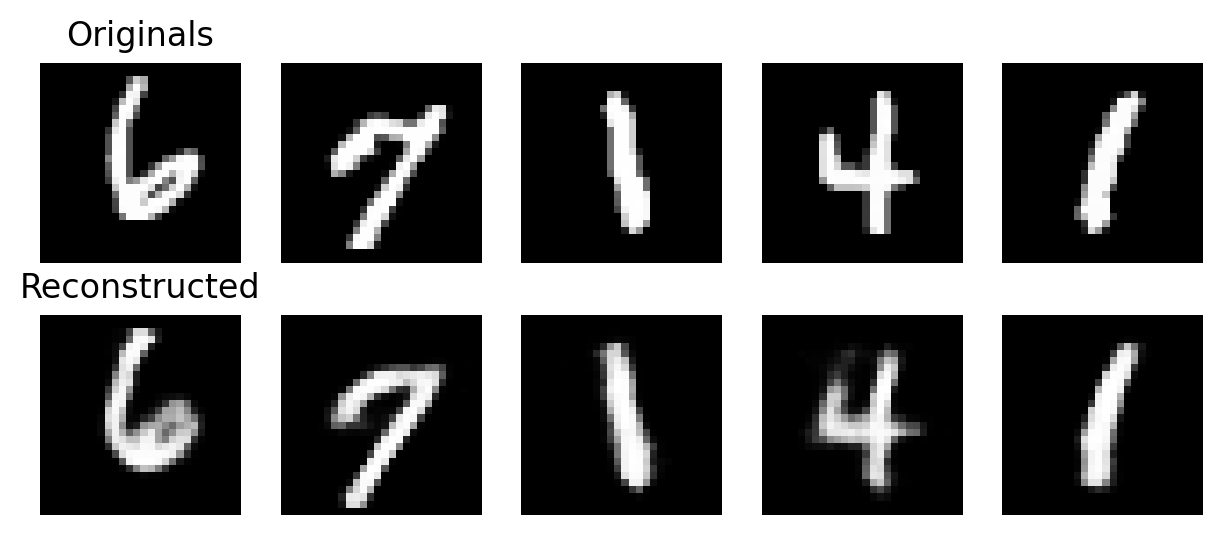

Training 5-layer autoencoder with projected dimension 100
Epoch 0. Training loss: 0.2831457867554039. Validation loss: 0.2305662824383265
Epoch 1. Training loss: 0.19607917632266975. Validation loss: 0.1717585645898988
Epoch 2. Training loss: 0.14293152696577607. Validation loss: 0.13304951551217067
Epoch 3. Training loss: 0.12009795043309024. Validation loss: 0.11791531402098981
Epoch 4. Training loss: 0.10706923897289167. Validation loss: 0.10519625397422645
Epoch 5. Training loss: 0.09790300843632145. Validation loss: 0.09974444072835054
Epoch 6. Training loss: 0.0898349251432024. Validation loss: 0.09216441034893447
Epoch 7. Training loss: 0.08383368439735121. Validation loss: 0.08626965527670293
Epoch 8. Training loss: 0.07872199338332862. Validation loss: 0.0827524580910236
Epoch 9. Training loss: 0.07508843833473837. Validation loss: 0.08099162842653974


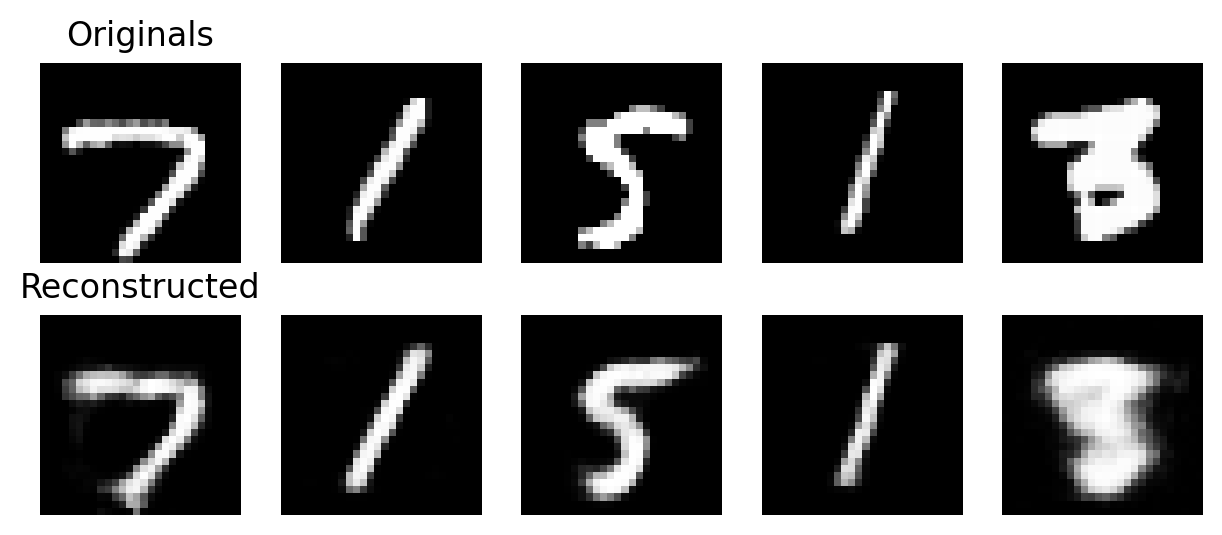

In [12]:
# Hyperparameter Configurations
layer_configs = {
    "3-layer": [512, 128],
    "5-layer": [512, 256, 128, 32]
}
projected_dims = [15, 30, 50, 100]

results_train = {}
results_valid = {}

for name, layers in layer_configs.items():
    for proj_dim in projected_dims:
        print(f"Training {name} autoencoder with projected dimension {proj_dim}")

        autoencoder = AutoencoderExtended(dimx=784, hidden_dims=layers, projected=proj_dim, epochs=10
                                          , lr=0.001)

        autoencoder.trainloop(trainloader_subset, validloader_subset)
        autoencoder.plot_reconstructions(testloader)

        # Store results
        results_train[(name, proj_dim)] = autoencoder.loss_during_training
        results_valid[(name, proj_dim)] = autoencoder.valid_loss_during_training


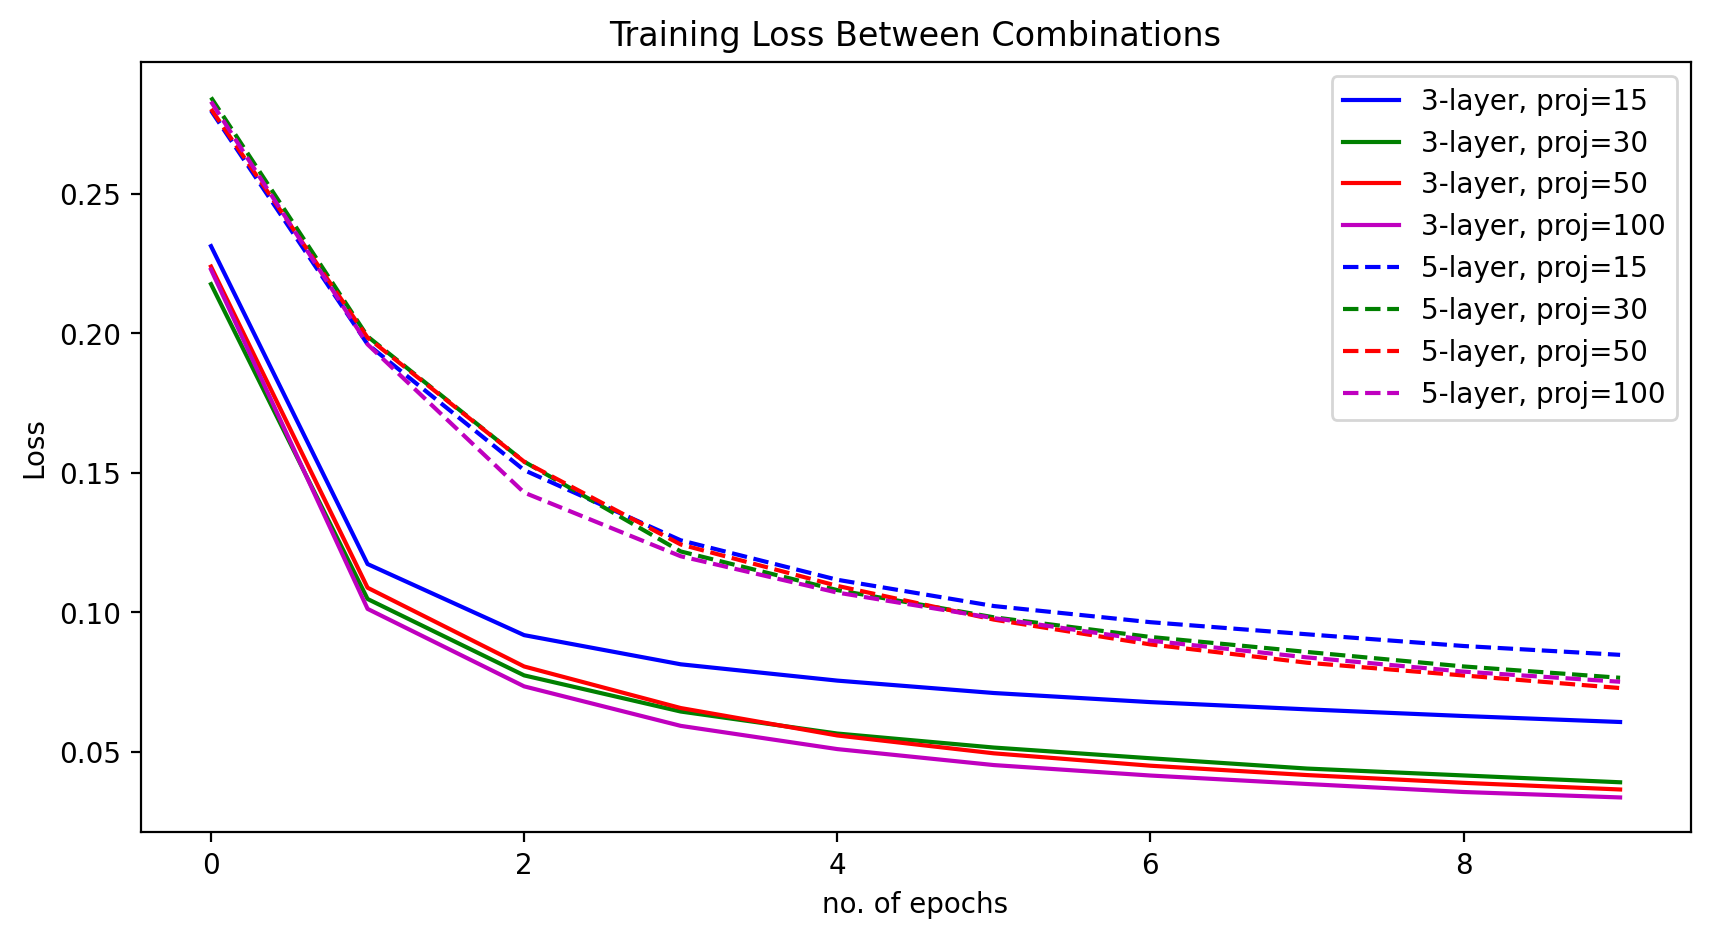

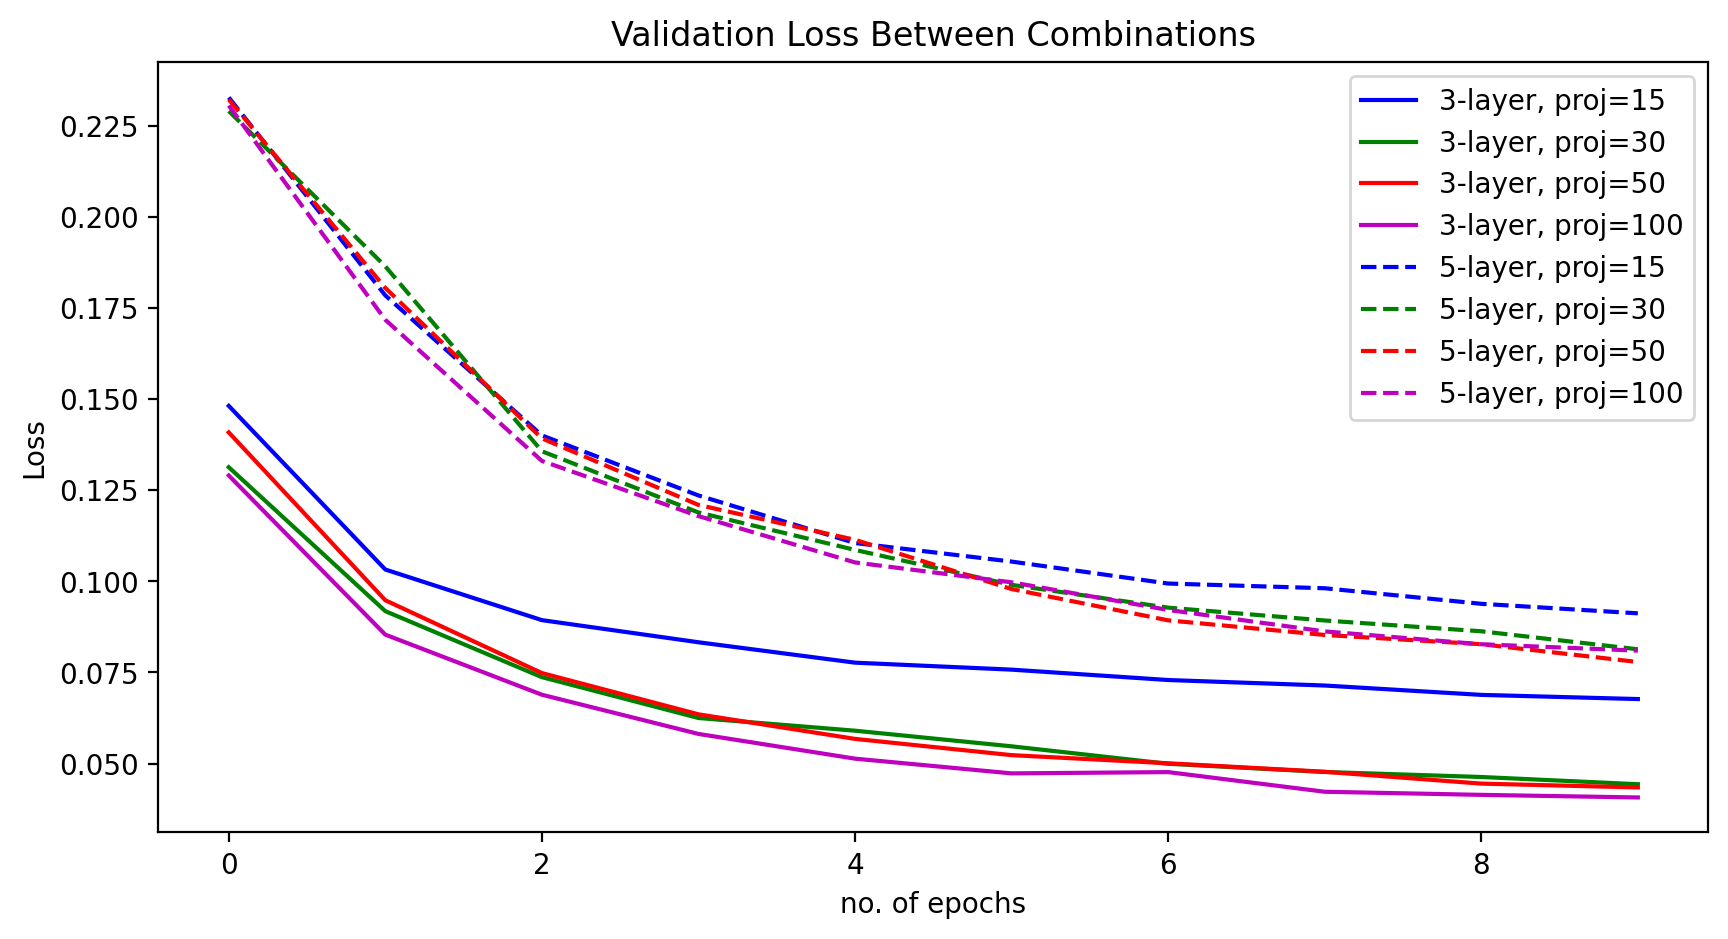

In [13]:
# Plot Loss Curve
def plot_losses(losses, title):
    plt.figure(figsize=(10, 5))
    colors = ['b', 'g', 'r', 'm']
    linestyles = {'3-layer': '-', '5-layer': '--'}

    for i, ((name, proj_dim), losses) in enumerate(losses.items()):
        color = colors[i % len(colors)]
        linestyle = linestyles[name]
        plt.plot(losses, label=f"{name}, proj={proj_dim}", color=color, linestyle=linestyle)

    plt.xlabel("no. of epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} Loss Between Combinations")
    plt.legend()
    plt.show()

# Plot Training and Validation Losses
plot_losses(results_train, "Training")
plot_losses(results_valid, "Validation")

Once we have checked the best number of layers and latent space dimensions, the parameter that is left without considering any regularization technique is the learning rate.

Training with learning rate: 0.0001
Epoch 0. Training loss: 0.3776562896313941. Validation loss: 0.26725750369361684
Epoch 1. Training loss: 0.23699532155018704. Validation loss: 0.21297399699687958
Epoch 2. Training loss: 0.19231824368048625. Validation loss: 0.17980703051331676
Epoch 3. Training loss: 0.1565845914327415. Validation loss: 0.14718197738822503
Epoch 4. Training loss: 0.13339307339517933. Validation loss: 0.12702136939462227


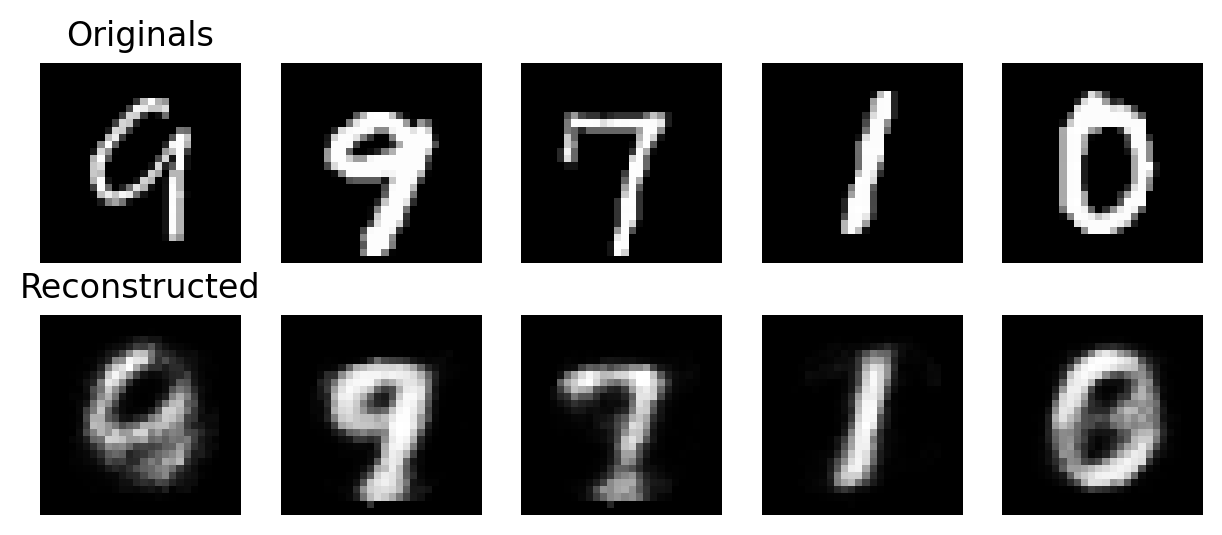

Training with learning rate: 0.001
Epoch 0. Training loss: 0.218565679896789. Validation loss: 0.1252869002615349
Epoch 1. Training loss: 0.10256782283259046. Validation loss: 0.09338550618554972
Epoch 2. Training loss: 0.07670362189317205. Validation loss: 0.07122610122719898
Epoch 3. Training loss: 0.06181961281379317. Validation loss: 0.06220096481751792
Epoch 4. Training loss: 0.05331812528478112. Validation loss: 0.053964695928594736


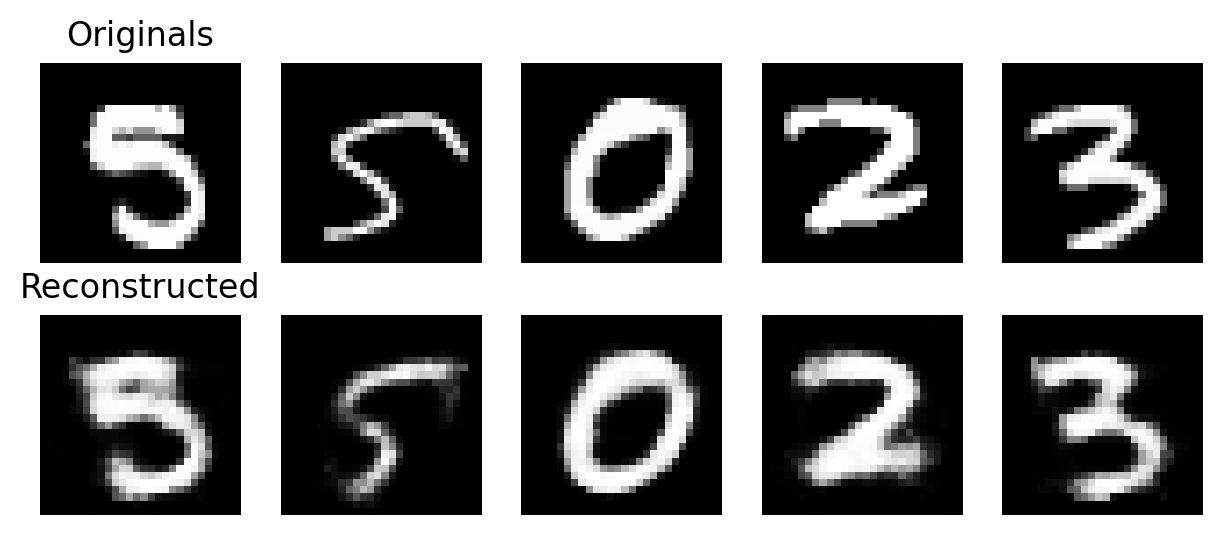

In [14]:
learning_rates = [0.0001, 0.001]

results_train_lr = {}
results_valid_lr = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    # Initialize the best model found
    autoencoder = AutoencoderExtended(dimx=28*28, hidden_dims=[512, 128], projected=100, epochs=5, lr=lr)
    autoencoder.trainloop(trainloader_subset, validloader_subset)
    autoencoder.plot_reconstructions(testloader)
    results_train_lr[lr] = autoencoder.loss_during_training
    results_valid_lr[lr] = autoencoder.valid_loss_during_training


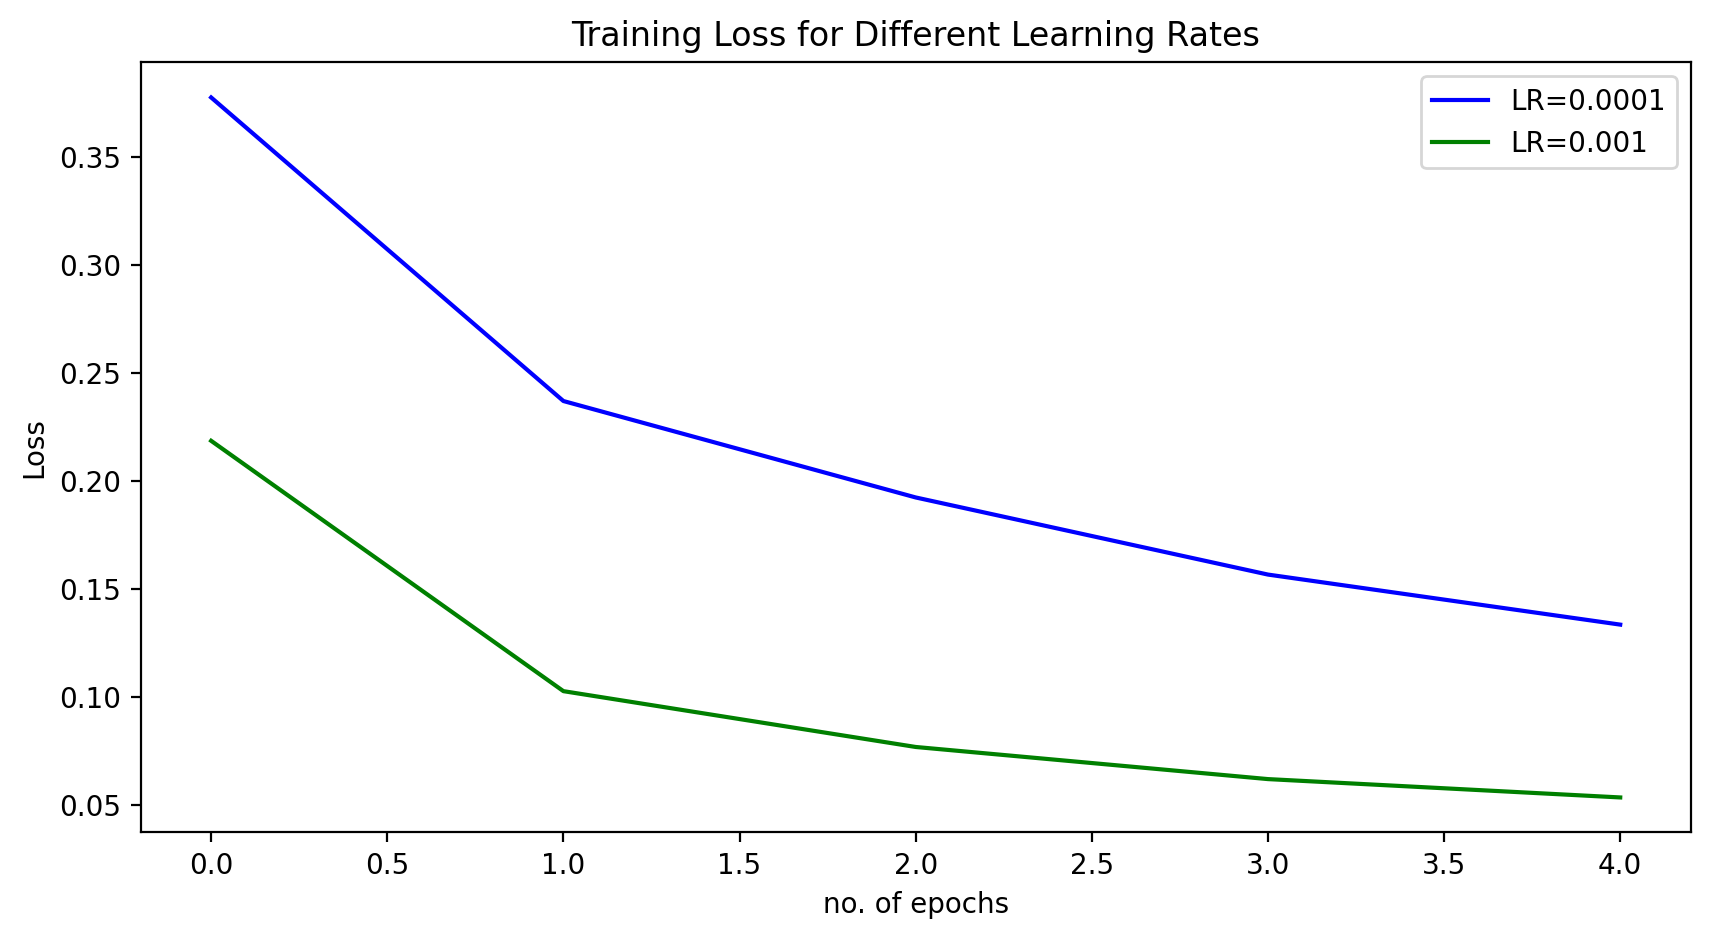

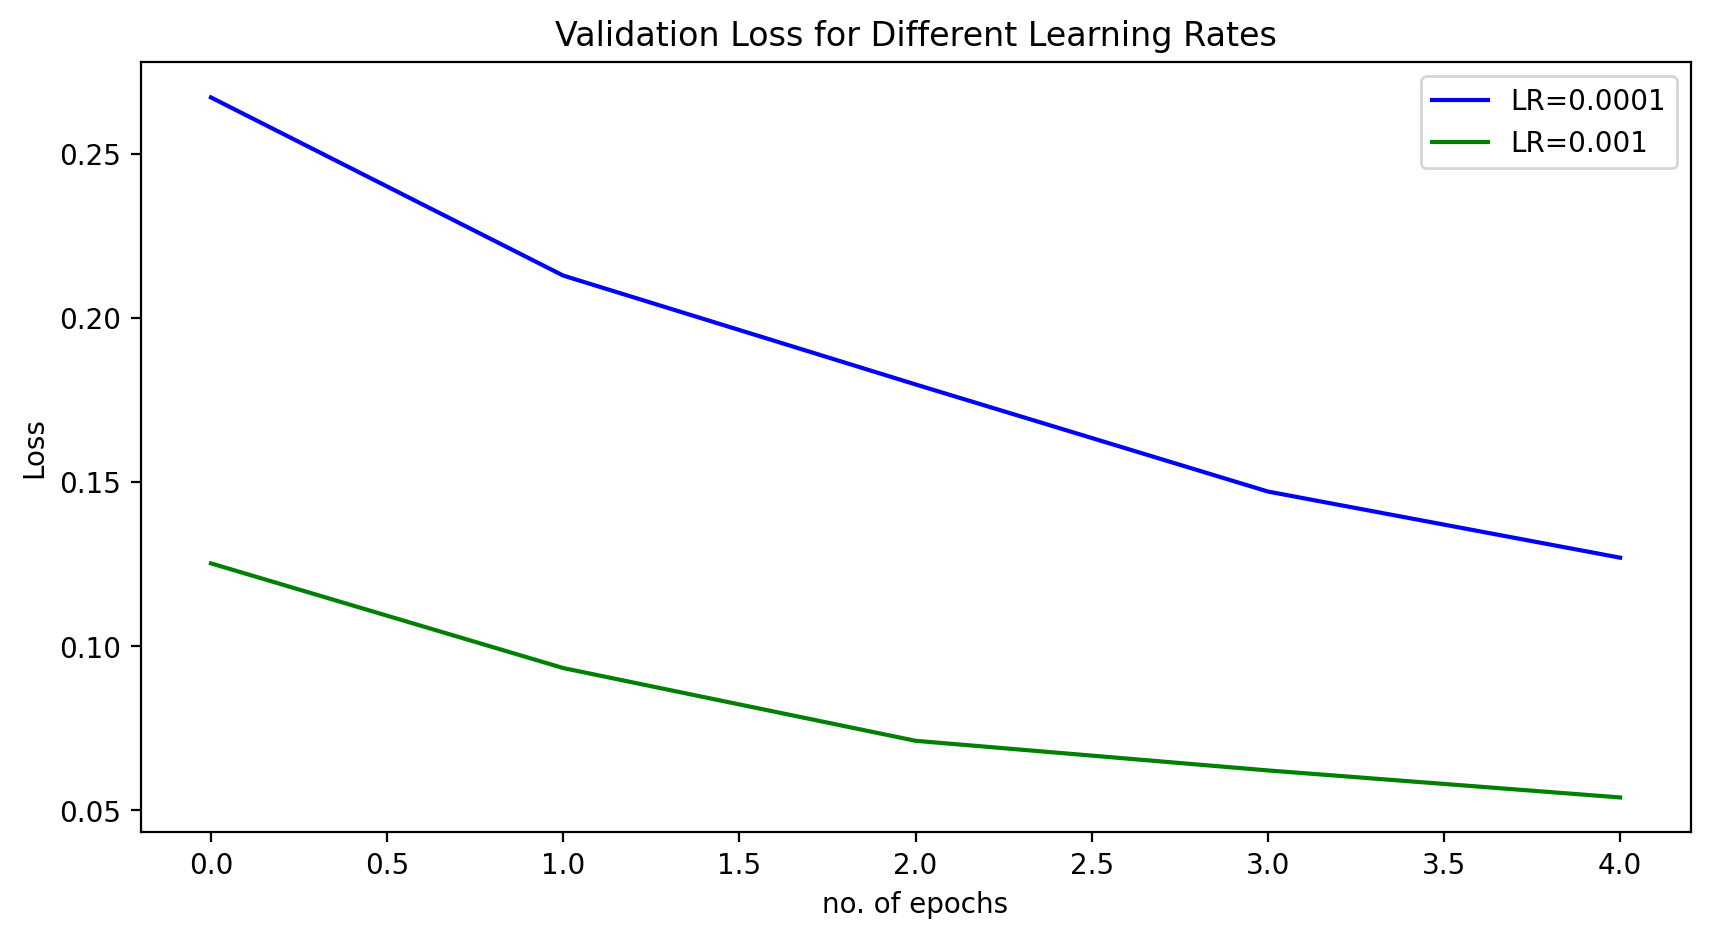

Best learning rate found: 0.001


In [15]:

# Plot Loss Curves for Different Learning Rates
def plot_lr_losses(results, title):
    plt.figure(figsize=(10, 5))
    
    colors = ['b', 'g', 'r', 'm', 'c', 'k']
    for i, (lr, losses) in enumerate(results.items()):
        plt.plot(losses, label=f"LR={lr}", color=colors[i % len(colors)])

    plt.xlabel("no. of epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Training and Validation Losses
plot_lr_losses(results_train_lr, "Training Loss for Different Learning Rates")
plot_lr_losses(results_valid_lr, "Validation Loss for Different Learning Rates")

# Learning Rate with lowest validation loss
best_lr = min(results_valid_lr, key=lambda lr: results_valid_lr[lr][-1])
print(f"Best learning rate found: {best_lr}")


Train the selected model

Epoch 0. Training loss: 0.1094173176468096. Validation loss: 0.0572940523161533
Epoch 1. Training loss: 0.04426456661101177. Validation loss: 0.04077999858146018
Epoch 2. Training loss: 0.034312733538999135. Validation loss: 0.03421793901064295
Epoch 3. Training loss: 0.029558115109631963. Validation loss: 0.0303852480856028
Epoch 4. Training loss: 0.026297082590066235. Validation loss: 0.029106566856833216
Epoch 5. Training loss: 0.024392948477973485. Validation loss: 0.027081434626845605
Epoch 6. Training loss: 0.022620084184878084. Validation loss: 0.026001968218925153
Epoch 7. Training loss: 0.02139148983405903. Validation loss: 0.024034667815616792
Epoch 8. Training loss: 0.020411935457642274. Validation loss: 0.024229377397197358
Epoch 9. Training loss: 0.019658589940676888. Validation loss: 0.023526134334029034
Epoch 10. Training loss: 0.018853429042130963. Validation loss: 0.02319232557523758
Epoch 11. Training loss: 0.01832148837539452. Validation loss: 0.021909004893708735
Ep

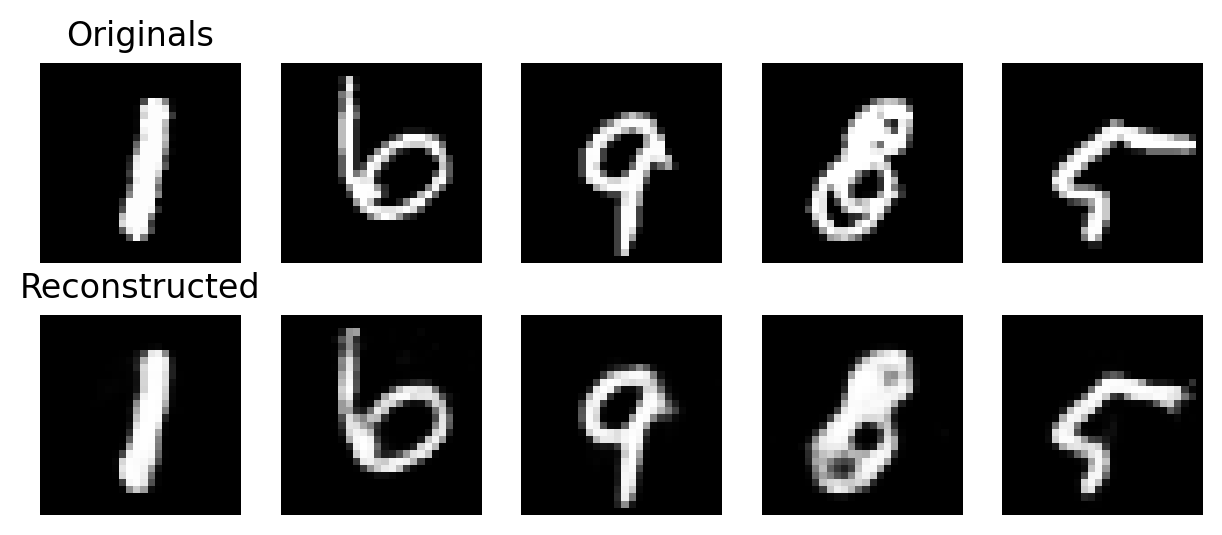

Mean reconstruction loss: 0.015663


In [17]:
autoencoder =  AutoencoderExtended(dimx=784, hidden_dims=[512, 128], projected=100, epochs=30, lr=1e-3)
autoencoder.trainloop(trainloader, validloader)
autoencoder.plot_reconstructions(testloader)
avg_loss = autoencoder.testloop(testloader)

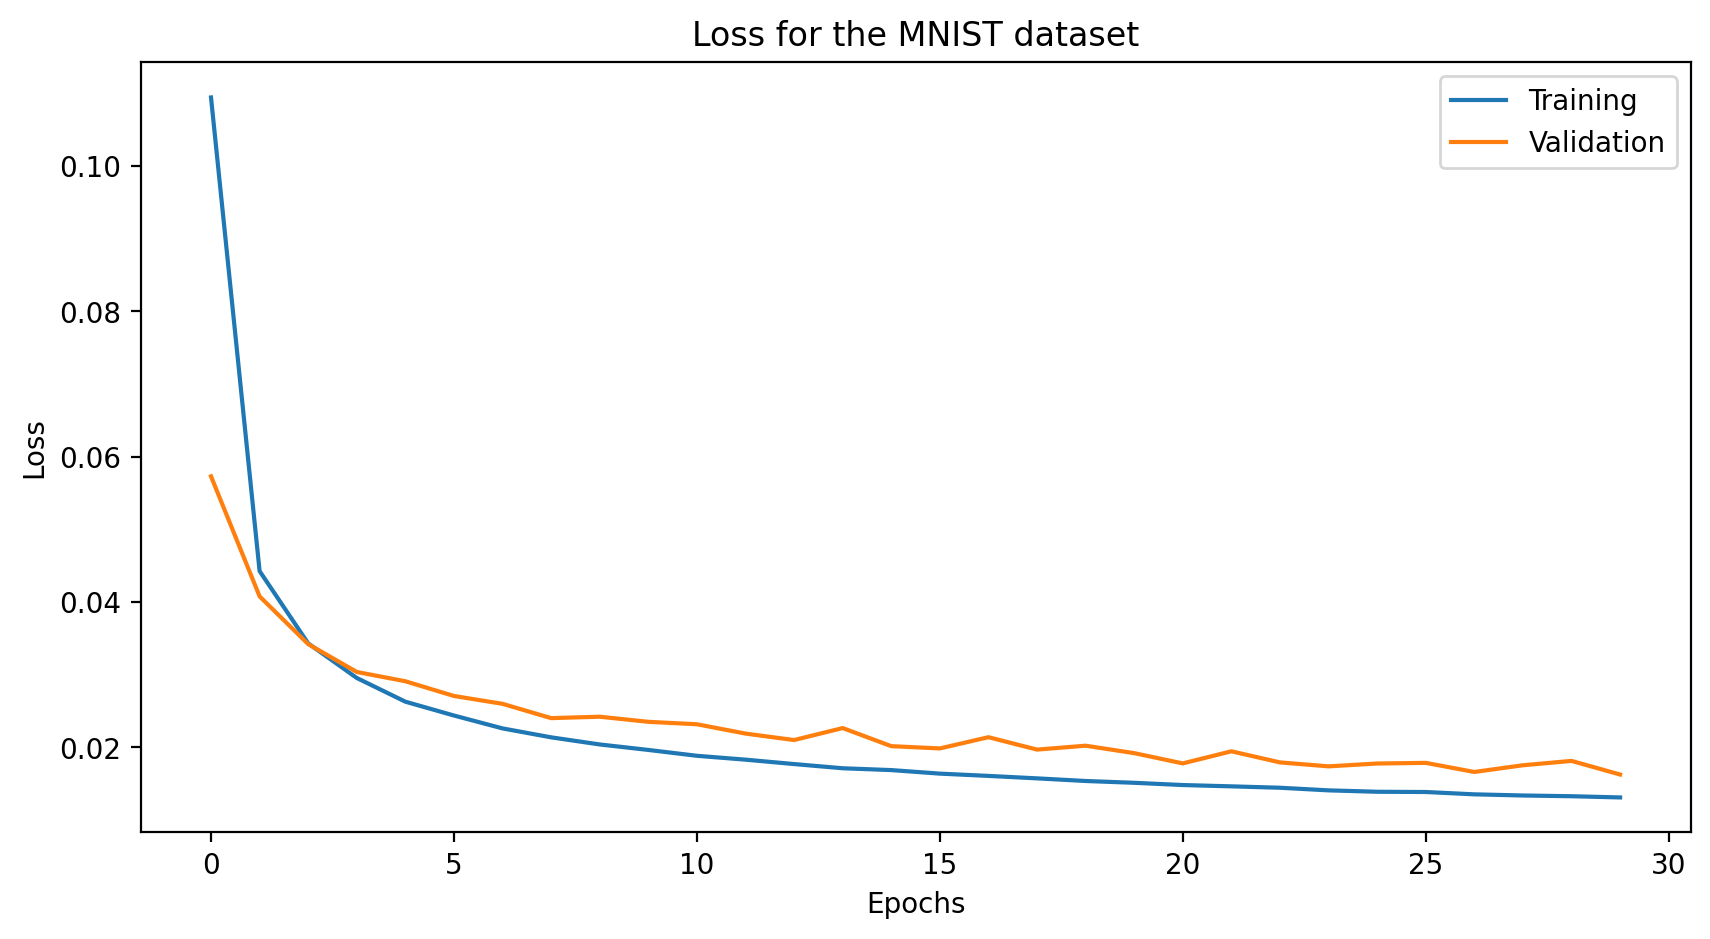

In [18]:
plt.figure(figsize=(10,5))
plt.plot(autoencoder.loss_during_training, label='Training')
plt.plot(autoencoder.valid_loss_during_training, label='Validation')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for the MNIST dataset')
plt.show()


## FMINST

In [19]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

# Create samples to train faster
train_subset_indices = list(range(10000))               # 10k images for training
valid_subset_indices = list(range(10000, 15000))       # 5k images for validation

train_subset = Subset(trainset, train_subset_indices)
valid_subset = Subset(trainset, valid_subset_indices)


# New dataloaders
trainloader_subset = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
validloader_subset = torch.utils.data.DataLoader(valid_subset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor(-1.) tensor(1.)


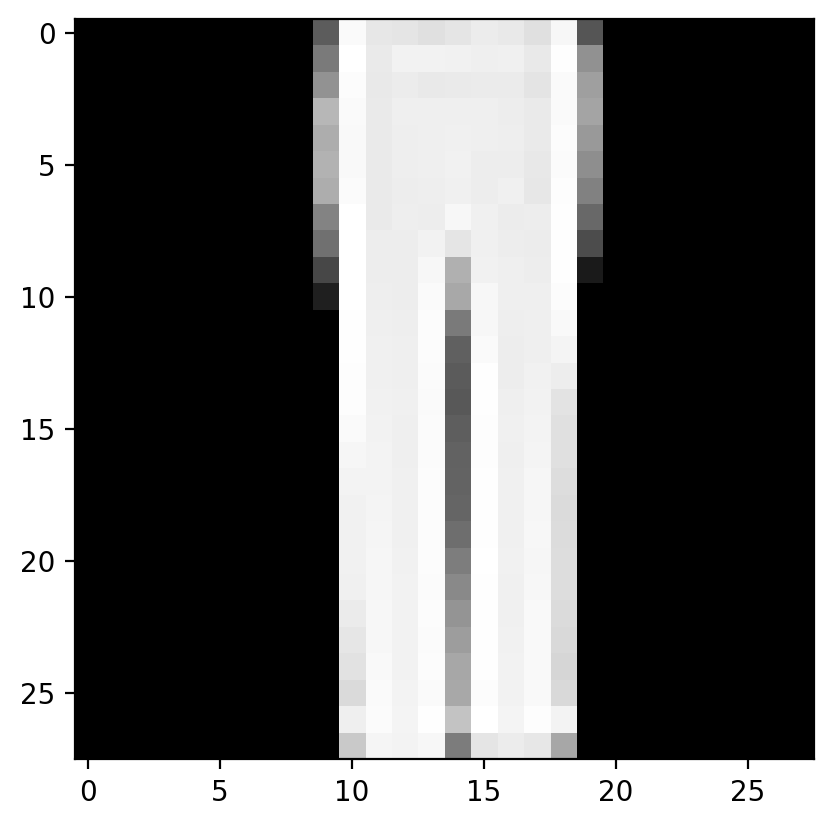

In [20]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)
print(torch.min(images), torch.max(images))
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

In [21]:
import torch
import random

# Define search space
three_layer_sizes = [512, 256, 128, 64]
five_layer_sizes = [512, 256, 128, 64, 32]
projected_dims = [15, 30, 50, 100]

# Store results
three_layer_options = []
five_layer_options = []

# Generate valid configurations for 3-layer autoencoder
for X in three_layer_sizes:
    for Y in three_layer_sizes:
        if X > Y:
            three_layer_options.append((X, Y))

# Generate valid configurations for 5-layer autoencoder
for A in five_layer_sizes:
    for B in five_layer_sizes:
        if A > B:
            for C in five_layer_sizes:
                if B > C:
                    for D in five_layer_sizes:
                        if C > D:
                            five_layer_options.append((A, B, C, D))

# Store results for different projections
results_train = {}
results_valid = {}

# Training loop for 3-layers
for config in random.sample(three_layer_options, 3):  # Select 3 random configurations
    for proj_dim in projected_dims:
        print(f"\n Training 3-layer Autoencoder | Hidden: {config} | Projected Dim: {proj_dim}")
        autoencoder = AutoencoderExtended(dimx=784, hidden_dims=config, projected=proj_dim, epochs=10, lr=0.001)
        autoencoder.trainloop(trainloader_subset, validloader_subset)
        results_train[('3-layer', config, proj_dim)] = autoencoder.loss_during_training
        results_valid[('3-layer', config, proj_dim)] = autoencoder.valid_loss_during_training

# Training loop for 5-layers
for config in random.sample(five_layer_options, 3):  # Select 3 random configurations
    for proj_dim in projected_dims:
        print(f"\nTraining 5-layer Autoencoder | Hidden: {config} | Projected Dim: {proj_dim}")
        autoencoder = AutoencoderExtended(dimx=784, hidden_dims=config, projected=proj_dim, epochs=10, lr=0.001)
        autoencoder.trainloop(trainloader_subset, validloader_subset)
        results_train[('5-layer', config, proj_dim)] = autoencoder.loss_during_training
        results_valid[('5-layer', config, proj_dim)] = autoencoder.valid_loss_during_training


 Training 3-layer Autoencoder | Hidden: (512, 256) | Projected Dim: 15
Epoch 0. Training loss: 0.15822765681963818. Validation loss: 0.09709003011259852
Epoch 1. Training loss: 0.08737292985437782. Validation loss: 0.08120679496964321
Epoch 2. Training loss: 0.0753483005864605. Validation loss: 0.07237834058984925
Epoch 3. Training loss: 0.06867473845364182. Validation loss: 0.06705960192823712
Epoch 4. Training loss: 0.06353855939807405. Validation loss: 0.06437774554272241
Epoch 5. Training loss: 0.06020029918972854. Validation loss: 0.06000701587977288
Epoch 6. Training loss: 0.05748142003063943. Validation loss: 0.05843726286216627
Epoch 7. Training loss: 0.05560100415519848. Validation loss: 0.05751385860428025
Epoch 8. Training loss: 0.05390880598573928. Validation loss: 0.057062145369716835
Epoch 9. Training loss: 0.05276277955550297. Validation loss: 0.0557260788222657

 Training 3-layer Autoencoder | Hidden: (512, 256) | Projected Dim: 30
Epoch 0. Training loss: 0.15858641779

In [22]:
# Find the best 3-layer and 5-layer configurations based on minimum validation loss
best_3_layer = min(
    ((key, loss) for key, loss in results_valid.items() if key[0] == '3-layer'),
    key=lambda x: x[1]
)

best_5_layer = min(
    ((key, loss) for key, loss in results_valid.items() if key[0] == '5-layer'),
    key=lambda x: x[1]
)

best_3_layer, best_5_layer

((('3-layer', (512, 256), 50),
  [0.09580390343937693,
   0.07780357497402385,
   0.0684103463080865,
   0.06264326259305206,
   0.05874760609261597,
   0.05496029569944249,
   0.05348556078498876,
   0.050823992047506046,
   0.048680162458102916,
   0.04774705466778972]),
 (('5-layer', (512, 256, 128, 32), 15),
  [0.1480553035117403,
   0.11363743151290508,
   0.0977527399229098,
   0.0906976593446128,
   0.08701286276307287,
   0.0815992327996447,
   0.07802524417638779,
   0.07631401566764977,
   0.07295048241562481,
   0.07124570016808147]))

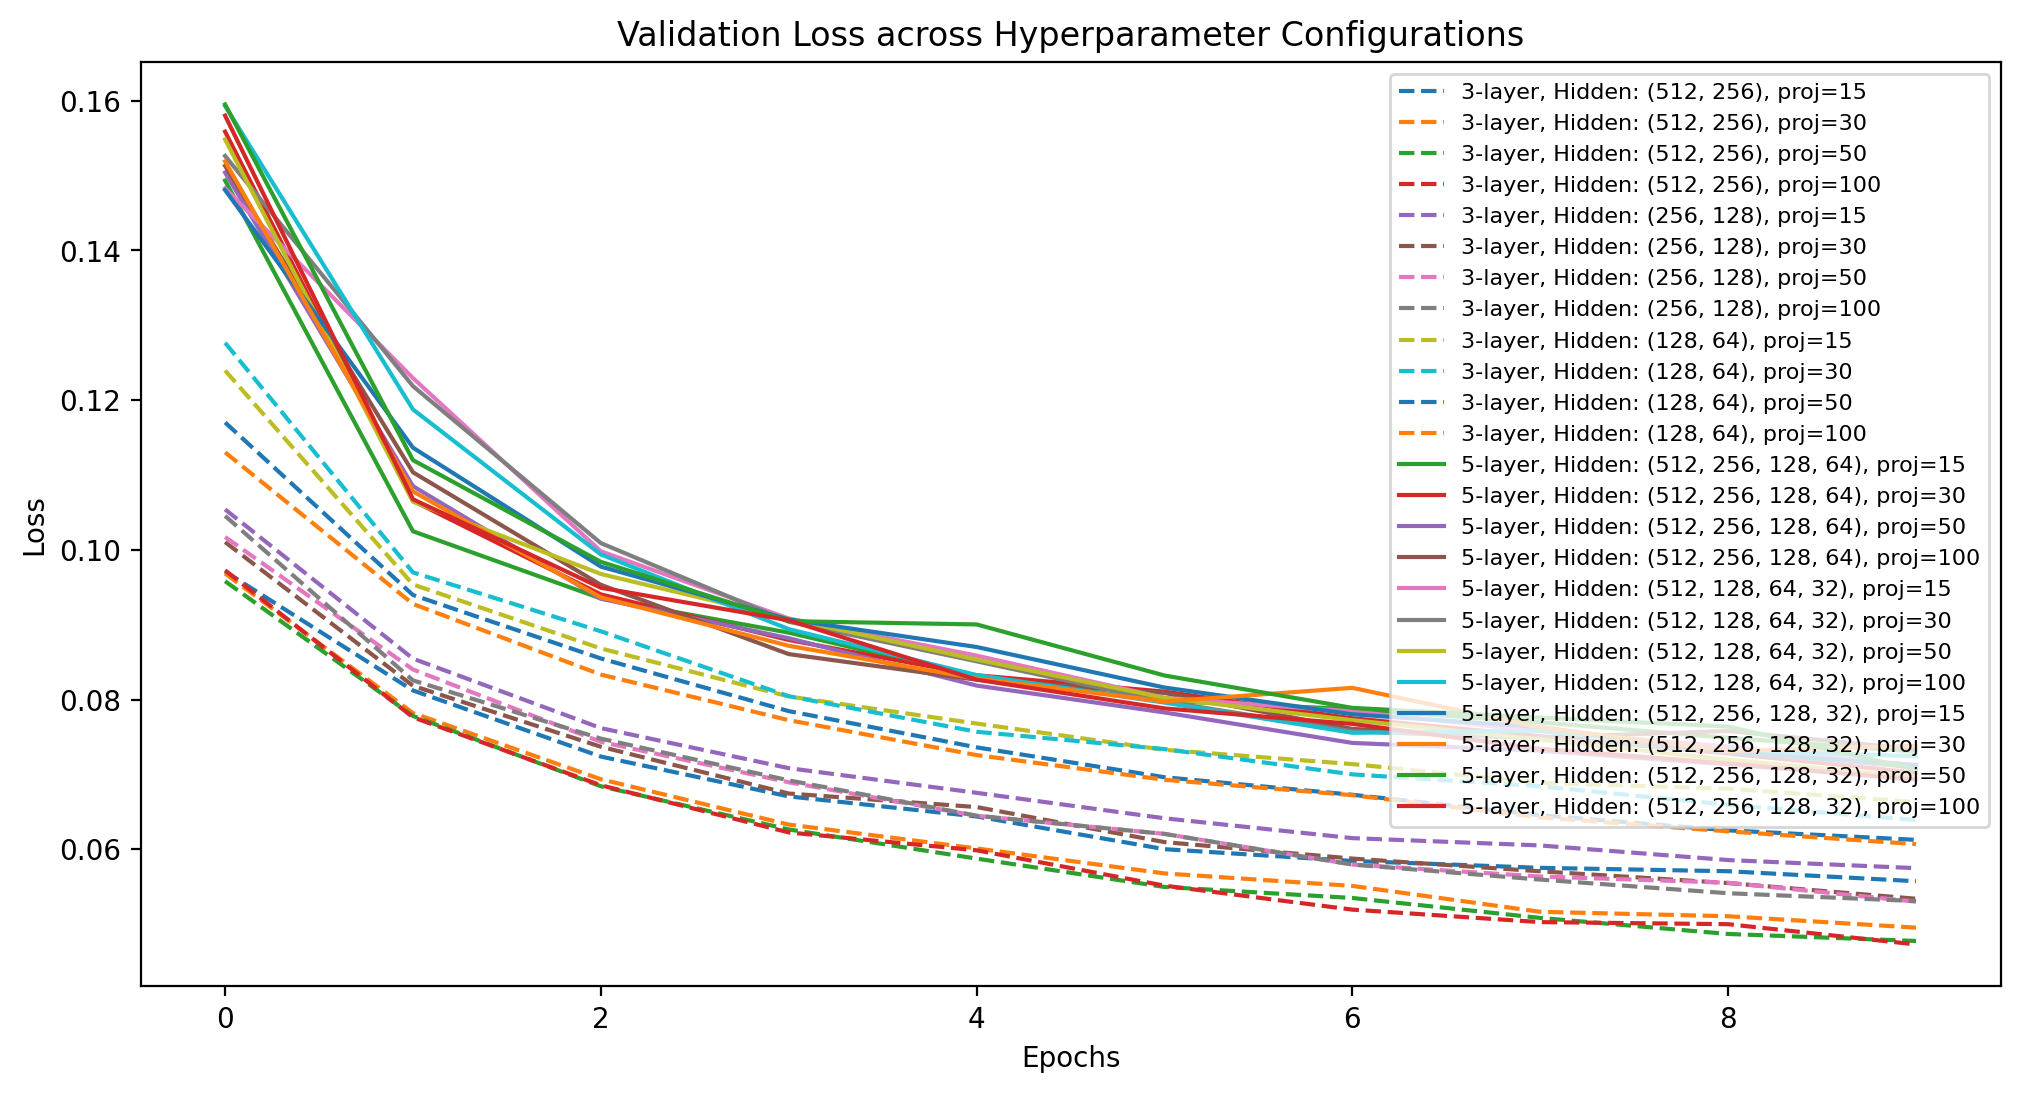

In [23]:

# Plot Loss Curve
import matplotlib.pyplot as plt

def plot_losses(results, type):
    """
    Plots the training/validation losses for different layer configurations and projection dimensions.
    results: Dictionary containing losses for different architectures, hidden layer configurations, and projected dimensions.
    title: 'Training Loss' or 'Validation Loss').
    """
    plt.figure(figsize=(12, 6))

    for (name, config, proj_dim), losses in results.items():
        if name == "3-layer":
            linestyle = '--'
        else:
            linestyle = '-'
        label = f"{name}, Hidden: {config}, proj={proj_dim}"
        plt.plot(losses, linestyle=linestyle, label=label)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(type)
    plt.legend(loc="best", fontsize=8)
    plt.show()

# Plot Validation Losses
plot_losses(results_valid, "Validation Loss across Hyperparameter Configurations")


We found the best hidden layer dimension combination to be (minimizes the MSE loss):
- 3-layer: [512, 256]
- 5-layer: [512, 256, 128, 32]

Training 3-layer autoencoder with projected dimension 15
Epoch 0. Training loss: 0.16248133854501567. Validation loss: 0.09729249058644983
Epoch 1. Training loss: 0.08591086597769124. Validation loss: 0.07829244887527032
Epoch 2. Training loss: 0.07261493256327453. Validation loss: 0.06868942072497139
Epoch 3. Training loss: 0.06544913090528197. Validation loss: 0.0644603253259689
Epoch 4. Training loss: 0.060885217372968696. Validation loss: 0.06111683885130701
Epoch 5. Training loss: 0.057388034690717224. Validation loss: 0.057597458456890495
Epoch 6. Training loss: 0.054512891989604684. Validation loss: 0.055809366976535775
Epoch 7. Training loss: 0.05259391907483909. Validation loss: 0.05418275683363782
Epoch 8. Training loss: 0.05078942603935861. Validation loss: 0.05326263375486
Epoch 9. Training loss: 0.04954806193234814. Validation loss: 0.05152848480811602


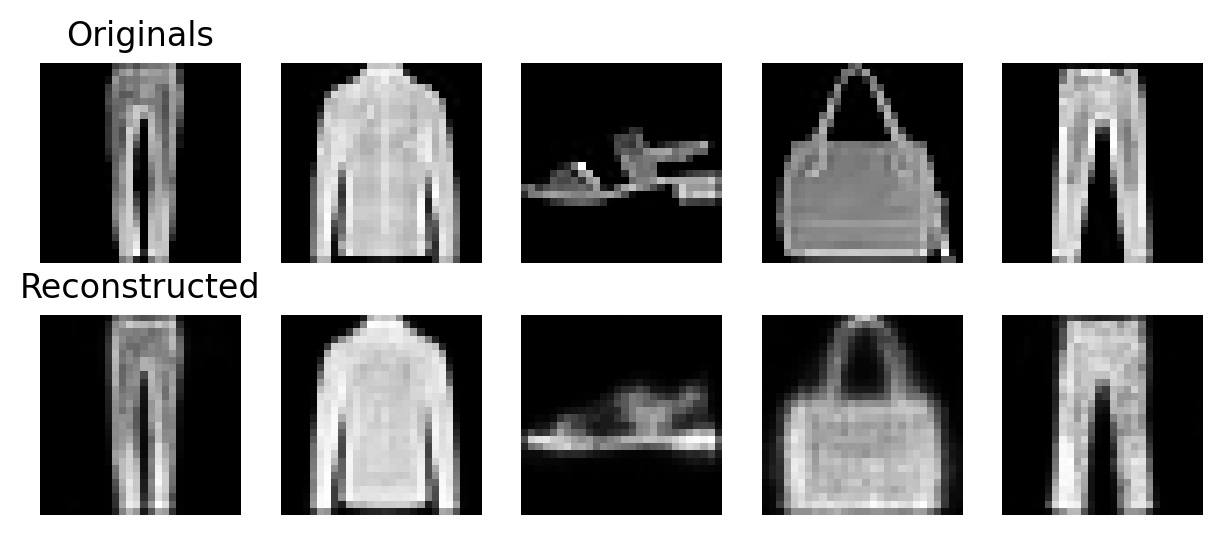

Training 3-layer autoencoder with projected dimension 30
Epoch 0. Training loss: 0.156607852857204. Validation loss: 0.09504061852452121
Epoch 1. Training loss: 0.08343129956228718. Validation loss: 0.07744935654763933
Epoch 2. Training loss: 0.07168292510471526. Validation loss: 0.06827101700856716
Epoch 3. Training loss: 0.06485727939541173. Validation loss: 0.0647781390366675
Epoch 4. Training loss: 0.059843213101671. Validation loss: 0.058595433784059334
Epoch 5. Training loss: 0.05573534566885347. Validation loss: 0.05600699612611457
Epoch 6. Training loss: 0.05261271444570487. Validation loss: 0.054535006797766385
Epoch 7. Training loss: 0.05024308566549781. Validation loss: 0.051394008052877235
Epoch 8. Training loss: 0.04820094649104556. Validation loss: 0.05012411841108829
Epoch 9. Training loss: 0.04655048882315872. Validation loss: 0.04917455554197106


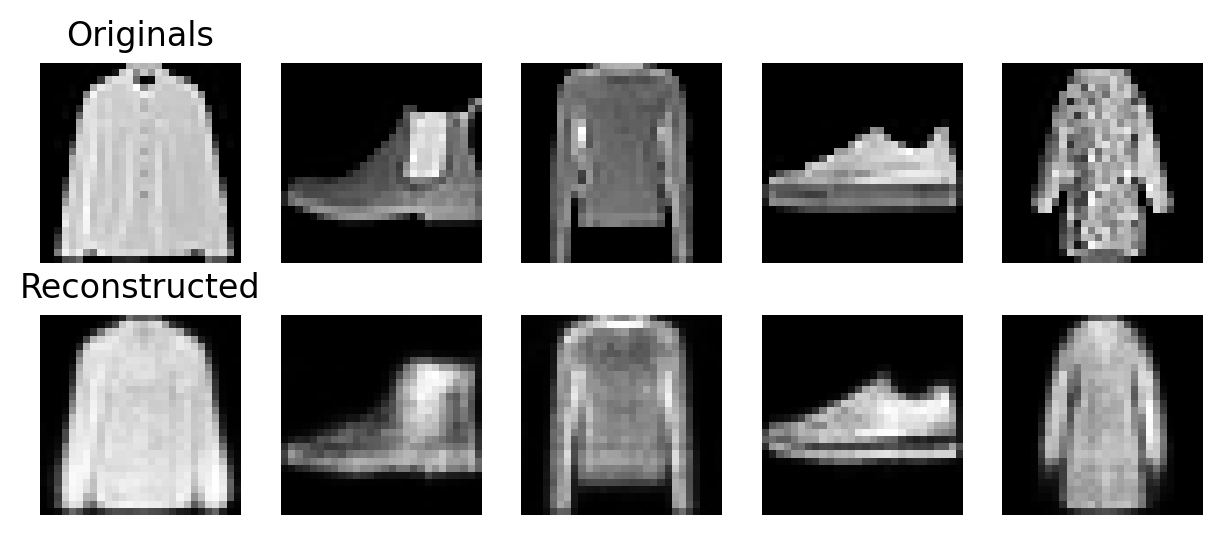

Training 3-layer autoencoder with projected dimension 50
Epoch 0. Training loss: 0.16072399862063158. Validation loss: 0.09475572039432163
Epoch 1. Training loss: 0.08399072360650749. Validation loss: 0.07690575624568553
Epoch 2. Training loss: 0.07141289914584463. Validation loss: 0.06784719101424459
Epoch 3. Training loss: 0.06398208344438273. Validation loss: 0.062343324994361855
Epoch 4. Training loss: 0.058872424137250634. Validation loss: 0.058803549248583706
Epoch 5. Training loss: 0.055101119551309356. Validation loss: 0.05520275456807281
Epoch 6. Training loss: 0.05225589104993328. Validation loss: 0.05291533823820609
Epoch 7. Training loss: 0.04983274339680459. Validation loss: 0.05109964947723135
Epoch 8. Training loss: 0.047709103602512626. Validation loss: 0.04982054577786711
Epoch 9. Training loss: 0.04588924068364368. Validation loss: 0.048417385856184776


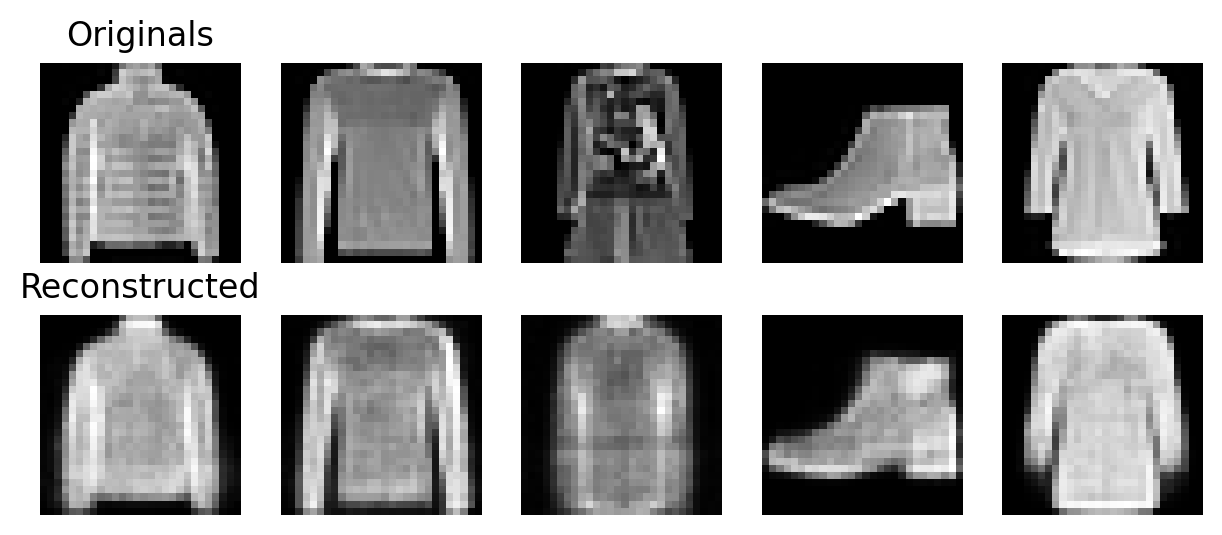

Training 3-layer autoencoder with projected dimension 100
Epoch 0. Training loss: 0.16015263993269319. Validation loss: 0.09615194740929181
Epoch 1. Training loss: 0.08551887645842923. Validation loss: 0.07745603792652299
Epoch 2. Training loss: 0.0720384515062639. Validation loss: 0.0680095073354395
Epoch 3. Training loss: 0.06507983941371275. Validation loss: 0.06270466598717472
Epoch 4. Training loss: 0.059538110639828785. Validation loss: 0.05867483905410465
Epoch 5. Training loss: 0.05526124116531603. Validation loss: 0.05597714579935315
Epoch 6. Training loss: 0.052361435666205776. Validation loss: 0.053687144259486015
Epoch 7. Training loss: 0.05006938176170276. Validation loss: 0.052014031742192525
Epoch 8. Training loss: 0.047862825523706. Validation loss: 0.04973567069708547
Epoch 9. Training loss: 0.046002260272859766. Validation loss: 0.04846545926566365


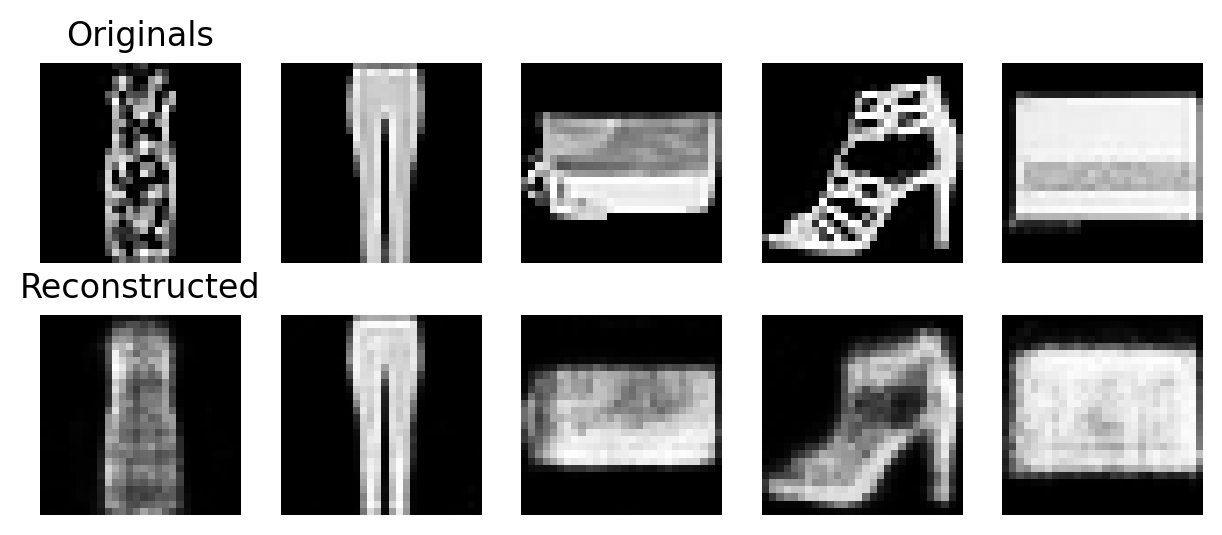

Training 5-layer autoencoder with projected dimension 15
Epoch 0. Training loss: 0.2290790894418765. Validation loss: 0.14820049721983414
Epoch 1. Training loss: 0.1217596793345585. Validation loss: 0.10419747827551033
Epoch 2. Training loss: 0.09759776503037496. Validation loss: 0.09477000721270525
Epoch 3. Training loss: 0.09023510118958297. Validation loss: 0.08679397158984896
Epoch 4. Training loss: 0.0850813071818868. Validation loss: 0.08326041076002241
Epoch 5. Training loss: 0.0809465637252589. Validation loss: 0.08023714613688143
Epoch 6. Training loss: 0.07759593019060268. Validation loss: 0.07723540355321727
Epoch 7. Training loss: 0.07536553202351187. Validation loss: 0.07453012607897384
Epoch 8. Training loss: 0.07248967745976084. Validation loss: 0.07266596926352646
Epoch 9. Training loss: 0.06988708591859812. Validation loss: 0.07179821362789673


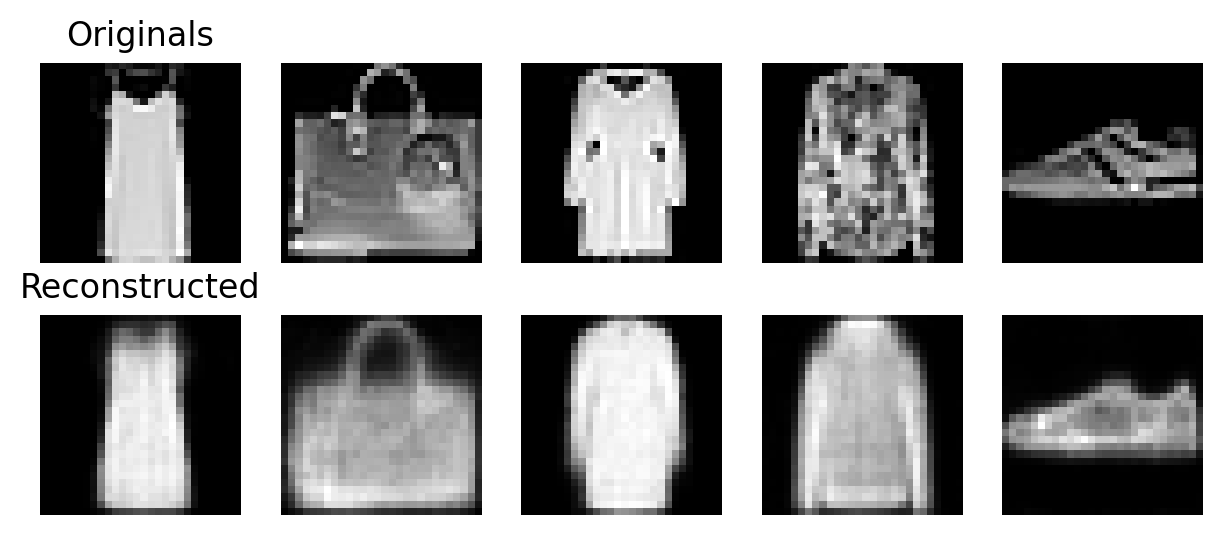

Training 5-layer autoencoder with projected dimension 30
Epoch 0. Training loss: 0.24828673396140907. Validation loss: 0.1547262591274479
Epoch 1. Training loss: 0.13151493583135543. Validation loss: 0.11275433654649349
Epoch 2. Training loss: 0.10085747770632908. Validation loss: 0.09510776089339316
Epoch 3. Training loss: 0.09043506936282869. Validation loss: 0.08853508333993863
Epoch 4. Training loss: 0.08456666359476223. Validation loss: 0.08167186737815037
Epoch 5. Training loss: 0.08011370674250232. Validation loss: 0.07802701722594756
Epoch 6. Training loss: 0.0765096386716624. Validation loss: 0.07743576404791844
Epoch 7. Training loss: 0.07459618957938662. Validation loss: 0.07402254301535932
Epoch 8. Training loss: 0.07161703921712129. Validation loss: 0.07220860863033729
Epoch 9. Training loss: 0.06971263306535733. Validation loss: 0.071004410804827


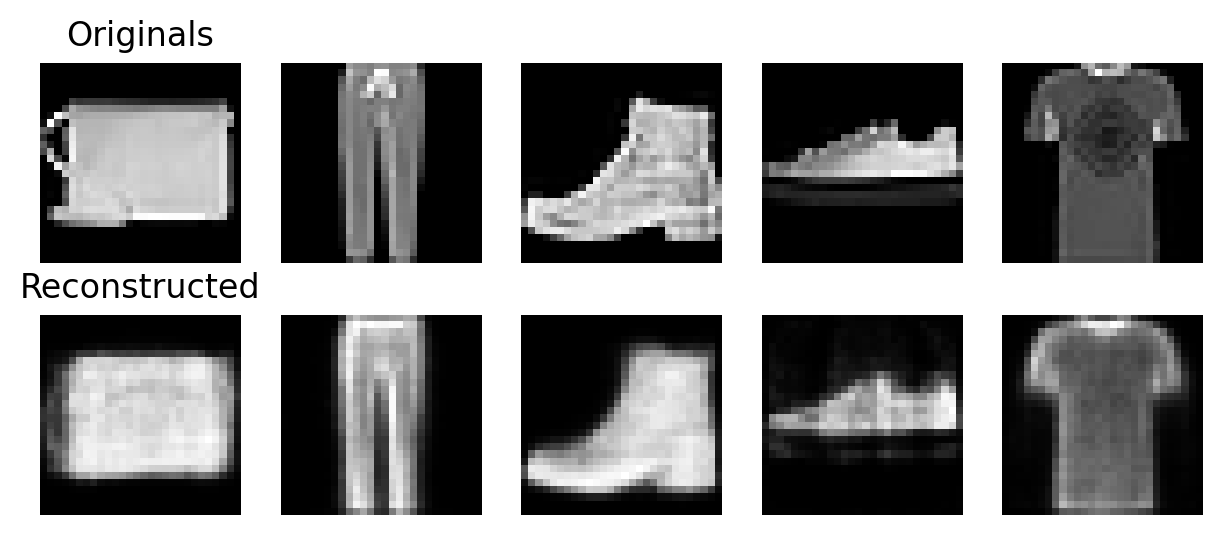

Training 5-layer autoencoder with projected dimension 50
Epoch 0. Training loss: 0.24086705951174353. Validation loss: 0.15372565162332752
Epoch 1. Training loss: 0.13022741333694215. Validation loss: 0.1109222200097917
Epoch 2. Training loss: 0.10136472414823094. Validation loss: 0.1000814760410333
Epoch 3. Training loss: 0.09277602242436378. Validation loss: 0.08919845747796795
Epoch 4. Training loss: 0.08527357216663421. Validation loss: 0.08425351543517053
Epoch 5. Training loss: 0.08066559763281209. Validation loss: 0.07847585774297956
Epoch 6. Training loss: 0.07693491895107707. Validation loss: 0.07631522940495346
Epoch 7. Training loss: 0.07445735339621071. Validation loss: 0.07713525647981258
Epoch 8. Training loss: 0.07228269883591658. Validation loss: 0.0736867798657357
Epoch 9. Training loss: 0.07013396793015443. Validation loss: 0.07224826929689962


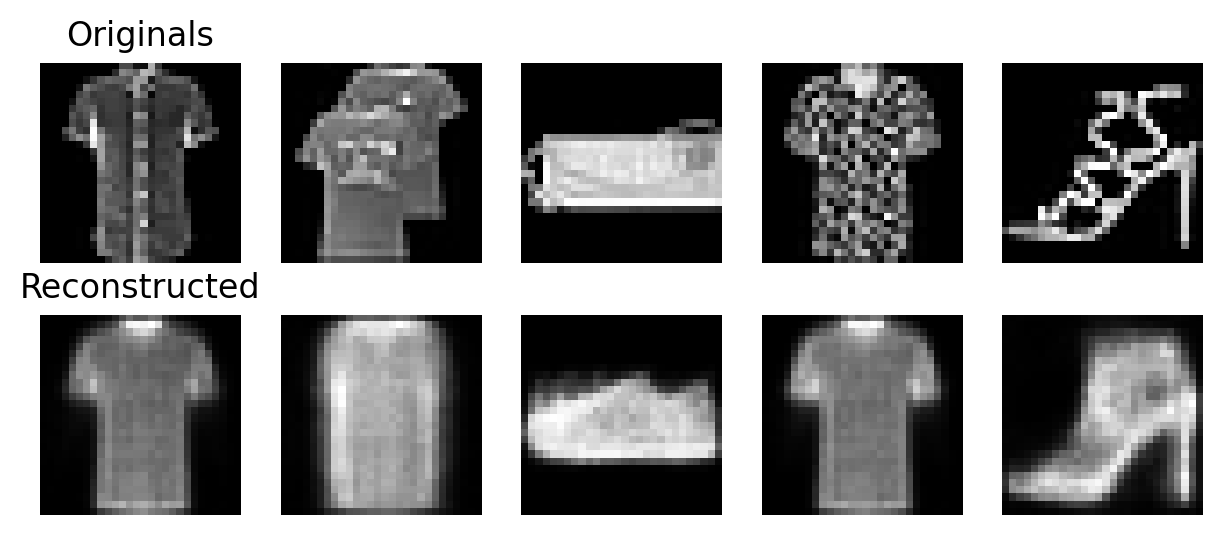

Training 5-layer autoencoder with projected dimension 100
Epoch 0. Training loss: 0.2359284775651944. Validation loss: 0.15377804863302014
Epoch 1. Training loss: 0.13137321620230463. Validation loss: 0.11278582835876488
Epoch 2. Training loss: 0.10079199246540191. Validation loss: 0.09632464337952529
Epoch 3. Training loss: 0.09103394181105741. Validation loss: 0.08809863794830781
Epoch 4. Training loss: 0.08501174315145821. Validation loss: 0.08399347762895536
Epoch 5. Training loss: 0.08122353625904982. Validation loss: 0.08119916123679921
Epoch 6. Training loss: 0.07738853521217966. Validation loss: 0.07744239270687103
Epoch 7. Training loss: 0.07438175363620375. Validation loss: 0.07506169435344165
Epoch 8. Training loss: 0.07216382619871456. Validation loss: 0.07372147721957557
Epoch 9. Training loss: 0.06926804845025585. Validation loss: 0.07036453749560102


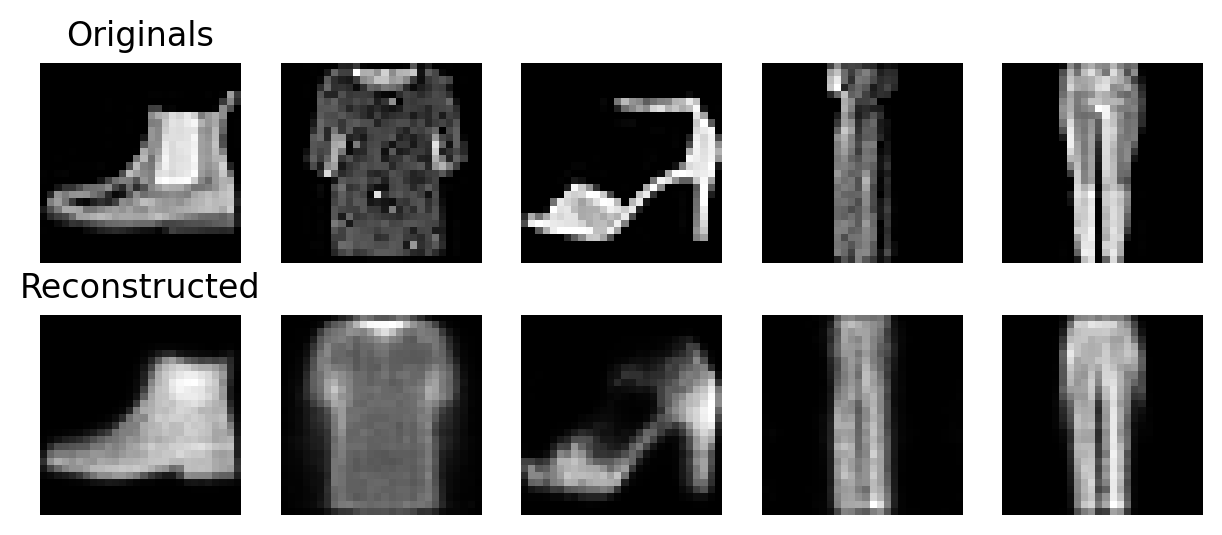

In [24]:
# Hyperparameter Configurations
layer_configs = {
    "3-layer": [512, 256],
    "5-layer": [512, 256, 128, 32]
}
projected_dims = [15, 30, 50, 100]

results_train = {}
results_valid = {}

for name, layers in layer_configs.items():
    for proj_dim in projected_dims:
        print(f"Training {name} autoencoder with projected dimension {proj_dim}")

        autoencoder = AutoencoderExtended(dimx=784, hidden_dims=layers, projected=proj_dim, epochs=10
                                          , lr=0.001)

        autoencoder.trainloop(trainloader_subset, validloader_subset)
        autoencoder.plot_reconstructions(testloader)

        # Store results
        results_train[(name, proj_dim)] = autoencoder.loss_during_training
        results_valid[(name, proj_dim)] = autoencoder.valid_loss_during_training


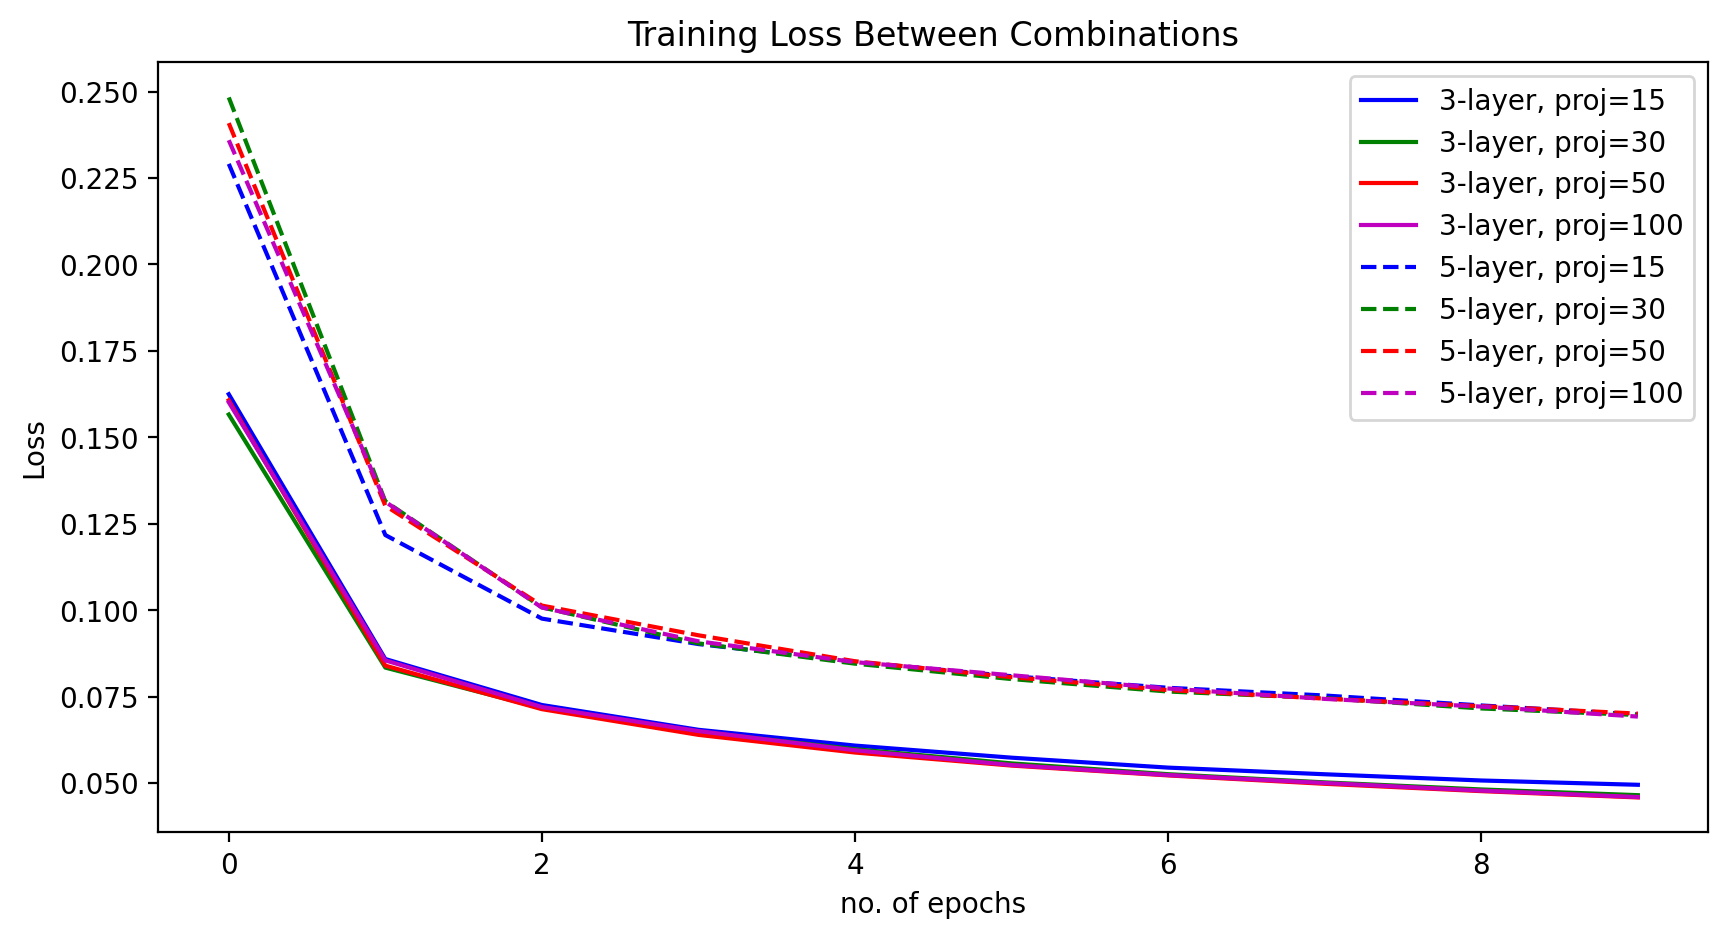

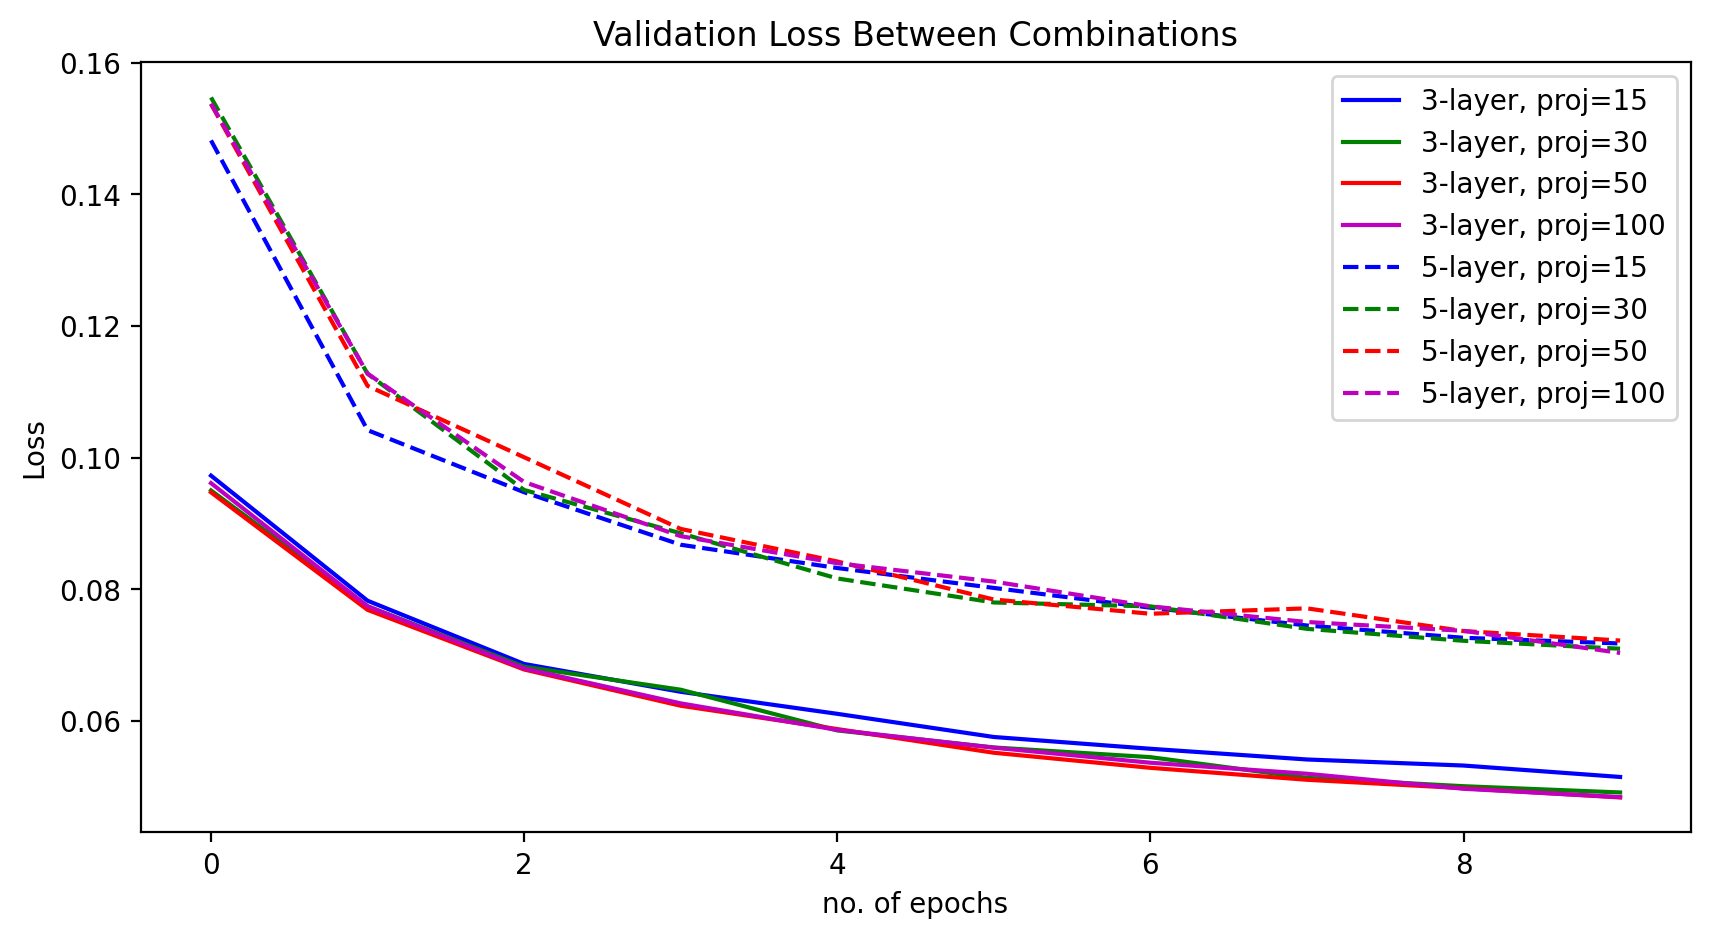

In [25]:
# Plot Loss Curve
def plot_losses(losses, title):
    plt.figure(figsize=(10, 5))
    colors = ['b', 'g', 'r', 'm']
    linestyles = {'3-layer': '-', '5-layer': '--'}

    for i, ((name, proj_dim), losses) in enumerate(losses.items()):
        color = colors[i % len(colors)]
        linestyle = linestyles[name]
        plt.plot(losses, label=f"{name}, proj={proj_dim}", color=color, linestyle=linestyle)

    plt.xlabel("no. of epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} Loss Between Combinations")
    plt.legend()
    plt.show()

# Plot Training and Validation Losses
plot_losses(results_train, "Training")
plot_losses(results_valid, "Validation")

Train the selected model using the lambda selected for the previous dataset as outperforms the other options:

Epoch 0. Training loss: 0.0921251160748811. Validation loss: 0.061362454342715284
Epoch 1. Training loss: 0.05372102671853182. Validation loss: 0.04946658860178704
Epoch 2. Training loss: 0.04542963730636984. Validation loss: 0.04374220209552886
Epoch 3. Training loss: 0.041062076115684416. Validation loss: 0.04183315476204487
Epoch 4. Training loss: 0.03834550550461493. Validation loss: 0.03892921688867376
Epoch 5. Training loss: 0.03637044861997393. Validation loss: 0.03803264661196699
Epoch 6. Training loss: 0.03474748158425262. Validation loss: 0.03673811967861145
Epoch 7. Training loss: 0.033596025830113584. Validation loss: 0.03597922361594565
Epoch 8. Training loss: 0.03255677911643447. Validation loss: 0.034975543832208245
Epoch 9. Training loss: 0.03164509040917354. Validation loss: 0.03353985713675935
Epoch 10. Training loss: 0.030784957960184493. Validation loss: 0.03336428723278198
Epoch 11. Training loss: 0.03008053252282976. Validation loss: 0.03252843552605903
Epoch 12. 

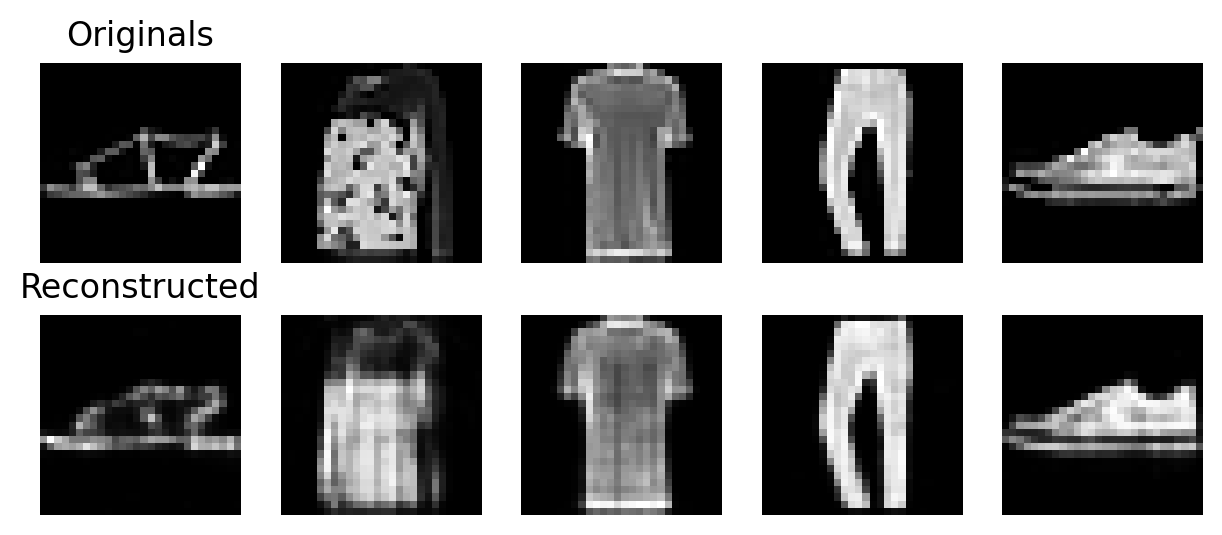

Mean reconstruction loss: 0.027769


In [26]:
autoencoder =  AutoencoderExtended(dimx=784, hidden_dims=[512, 256], projected=100, epochs=30, lr=1e-3)
autoencoder.trainloop(trainloader, validloader)
autoencoder.plot_reconstructions(testloader)
avg_loss = autoencoder.testloop(testloader)

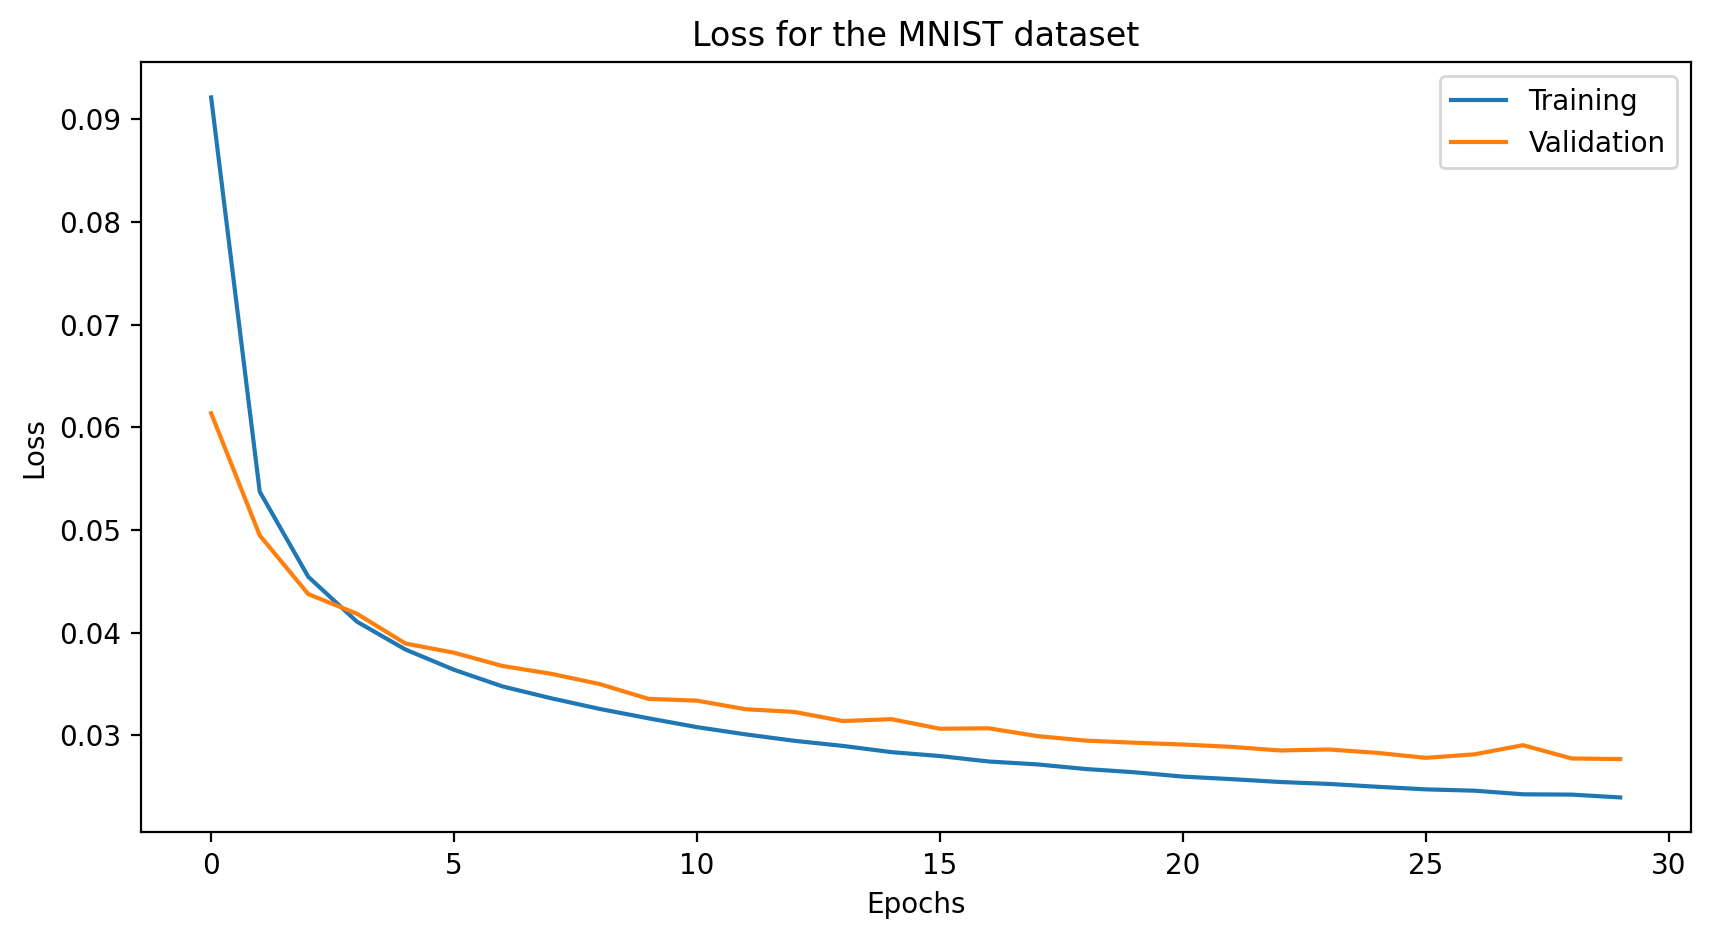

In [27]:
plt.figure(figsize=(10,5))
plt.plot(autoencoder.loss_during_training, label='Training')
plt.plot(autoencoder.valid_loss_during_training, label='Validation')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for the MNIST dataset')
plt.show()

## **Regularization Techniques**

### Lasso & Ridge Regularization 

In [55]:
class AutoencoderExtendedLasso(AutoencoderExtended):
    def __init__(self, dimx, hidden_dims, projected, epochs=30, lr=0.01, l1=0.001, l2=0.001):
        super().__init__(dimx, hidden_dims, projected, epochs, lr)
        self.l1 = l1
        self.l2 = l2

    def trainloop(self, trainloader, validloader):
        for e in range(self.epochs):
            running_loss = 0.
            for (inputs, _) in trainloader:
                inputs = inputs.reshape(inputs.shape[0], -1)
                out = self.forward(inputs)

                mse_loss = self.criterion(out, inputs)
                
                # Compute L1 and L2 penalties, iterating through parameters of the second-to-last encoder layer
                l1_reg = 0
                l2_reg = 0
                for param in self.encoder[-2].parameters():
                    l1_reg += torch.norm(param, p=1)  # (sparsity)
                    l2_reg += torch.norm(param, p=2)  # (weight decay)

                # Combine MSE loss with L1 and L2 regularization terms weighted by lambda
                loss = mse_loss + self.l1 * l1_reg + self.l2 * l2_reg
                running_loss += loss.item()

                # Update model weights
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

            # Track average training loss per epoch
            self.loss_during_training.append(running_loss / len(trainloader))

            # Validation loop (evaluate model on validation data)
            with torch.no_grad():
                running_loss = 0.
                for (inputs, _) in validloader:
                    inputs = inputs.reshape(inputs.shape[0], -1)
                    out = self.forward(inputs)
                    loss = self.criterion(out, inputs)
                    running_loss += loss.item()

                # Calculate average validation loss for the epoch
                self.valid_loss_during_training.append(running_loss / len(validloader))

            # Print training and validation loss
            if e % 1 == 0:
                print(f'Epoch {e}. Training loss: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}')



### Try more regularization techniques: Dropout

 
- Commented since based on the results we decided to explore other regularization techniques. No clear, overfitting.
- We added L2 reg.

In [ ]:
# class AutoencoderExtendedDropout(AutoencoderExtendedRegularization):
#     def __init__(self, dimx, hidden_dims, projected, epochs=30, lr=0.01, l1=0.001, l2= 0.001, dropout_rate=0.0):
#         """
#         Autoencoder with L1 and L2 regularization & dropout.
#         """
#         super().__init__(dimx, hidden_dims, projected, epochs, lr, l1, l2)
#         self.dropout = nn.Dropout(dropout_rate)  # Dropout layer

#         # Modify encoder to include dropout after activation
#         encoder_layers = []
#         prev_dim = dimx
#         for h in hidden_dims:
#             encoder_layers.append(nn.Linear(prev_dim, h))
#             encoder_layers.append(nn.LeakyReLU(0.1))  # Non-linearity
#             prev_dim = h
#         encoder_layers.append(nn.Linear(prev_dim, projected))
#         encoder_layers.append(nn.LeakyReLU(0.1))  # Activation
#         self.encoder = nn.Sequential(*encoder_layers)

#         # Modify decoder to include dropout after each activation
#         decoder_layers = []
#         prev_dim = projected
#         for h in reversed(hidden_dims):
#             decoder_layers.append(nn.Linear(prev_dim, h))
#             decoder_layers.append(nn.LeakyReLU(0.1))
#             prev_dim = h
#         decoder_layers.append(nn.Linear(prev_dim, dimx))
#         decoder_layers.append(nn.Tanh())  # Tanh for output activation
#         self.decoder = nn.Sequential(*decoder_layers)

#     def forward(self, x):
#         # Forward pass through the encoder
#         encoded = self.encoder(x)
        
#         # Apply dropout after the encoder output (during training)
#         if self.training:
#             encoded = self.dropout(encoded)  # Apply dropout only during training

#         # Forward pass through the decoder
#         decoded = self.decoder(encoded)
#         return decoded


Dropout Results

In [ ]:
# Testing Regularization: dropout=0.2
# Epoch 0. Training loss: 0.7146755175985349. Validation loss: 0.6830071022238913
# Epoch 1. Training loss: 0.7149950751833095. Validation loss: 0.6840744018554688
# Epoch 2. Training loss: 0.7147422664484401. Validation loss: 0.6828673919544944
# Epoch 3. Training loss: 0.7149946256807655. Validation loss: 0.6840430830098405
# Epoch 4. Training loss: 0.7148270303276694. Validation loss: 0.6833035349845886
# Epoch 5. Training loss: 0.7148210429082251. Validation loss: 0.6836644939229458
# Epoch 6. Training loss: 0.7146734796511899. Validation loss: 0.6838102099261706
# Epoch 7. Training loss: 0.7150052880785268. Validation loss: 0.6836671195452726
# Epoch 8. Training loss: 0.7148125399449828. Validation loss: 0.6839583093606973
# Epoch 9. Training loss: 0.7147043719413174. Validation loss: 0.683766968642609

### MNIST Dataset

In [56]:
from torch.utils.data import Subset


transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),]) # which scales the image values to [-1,1].
                              
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

# Create samples to train faster
train_subset_indices = list(range(10000))               # 10k images for training
valid_subset_indices = list(range(10000, 15000))       # 5k images for validation

train_subset = Subset(trainset, train_subset_indices)
valid_subset = Subset(trainset, valid_subset_indices)


# New dataloaders
trainloader_subset = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
validloader_subset = torch.utils.data.DataLoader(valid_subset, batch_size=64, shuffle=True)


In [57]:
# Hyperparameter combinations to test
l1_penalties = [0, 0.001, 0.01]
l2_penalties = [0, 0.001, 0.01]

def run_lasso_experiments():
    """ Run experiments with L1 and L2 regularization """
    for l1 in l1_penalties:
        for l2 in l2_penalties:
            print(f"Testing Lasso: l1={l1}, l2={l2}")
            
            model = AutoencoderExtendedLasso(
                dimx=784, 
                hidden_dims=[512, 128], 
                projected=100, 
                lr=1e-3, 
                l1=l1, 
                l2=l2,
                epochs=10
            )
            model.trainloop(trainloader_subset, validloader_subset)
            
            # Log final results
            print(f"Final Training Loss: {model.loss_during_training[-1]}, Final Validation Loss: {model.valid_loss_during_training[-1]}")

In [58]:
run_lasso_experiments()

Testing Lasso: l1=0, l2=0
Epoch 0. Training loss: 0.2265748794006694. Validation loss: 0.13049922958959506
Epoch 1. Training loss: 0.10365999257488615. Validation loss: 0.09065204208032994
Epoch 2. Training loss: 0.0760704325927291. Validation loss: 0.07026951161177852
Epoch 3. Training loss: 0.06099817185265243. Validation loss: 0.061277286680061605
Epoch 4. Training loss: 0.05203439100722598. Validation loss: 0.053297429522381555
Epoch 5. Training loss: 0.04613199153808272. Validation loss: 0.049303816655014134
Epoch 6. Training loss: 0.04165330242104591. Validation loss: 0.046090323713761344
Epoch 7. Training loss: 0.03876223254972582. Validation loss: 0.04279396159550811
Epoch 8. Training loss: 0.0361151343009844. Validation loss: 0.04170994795387304
Epoch 9. Training loss: 0.0338143409247611. Validation loss: 0.0405072390655928
Final Training Loss: 0.0338143409247611, Final Validation Loss: 0.0405072390655928
Testing Lasso: l1=0, l2=0.001
Epoch 0. Training loss: 0.2274538004284451

The best parameter combination appears to be the default autoencoder without any kind of regularization. 

### FMINST

In [59]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

# Create samples to train faster
train_subset_indices = list(range(10000))               # 10k images for training
valid_subset_indices = list(range(10000, 15000))       # 5k images for validation

train_subset = Subset(trainset, train_subset_indices)
valid_subset = Subset(trainset, valid_subset_indices)


# New dataloaders
trainloader_subset = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
validloader_subset = torch.utils.data.DataLoader(valid_subset, batch_size=64, shuffle=True)

In [60]:
# Hyperparameter combinations to test
l1_penalties = [0, 0.001, 0.01]
l2_penalties = [0, 0.001, 0.01]

def run_lasso_experiments():
    """ Run experiments with L1 and L2 regularization """
    for l1 in l1_penalties:
        for l2 in l2_penalties:
            print(f"Testing Lasso: l1={l1}, l2={l2}")
            
            model = AutoencoderExtendedLasso(
                dimx=784, 
                hidden_dims=[512, 256], 
                projected=100, 
                lr=1e-3, 
                l1=l1, 
                l2=l2,
                epochs=10
            )
            model.trainloop(trainloader_subset, validloader_subset)
            
            # Log final results
            print(f"Final Training Loss: {model.loss_during_training[-1]}, Final Validation Loss: {model.valid_loss_during_training[-1]}")

In [61]:
run_lasso_experiments()

Testing Lasso: l1=0, l2=0
Epoch 0. Training loss: 0.1574474888717293. Validation loss: 0.09562285866918444
Epoch 1. Training loss: 0.0842368487434782. Validation loss: 0.07712770668388921
Epoch 2. Training loss: 0.07195527711586588. Validation loss: 0.06887595468684088
Epoch 3. Training loss: 0.06494644452716894. Validation loss: 0.0626211122055597
Epoch 4. Training loss: 0.05899879761087667. Validation loss: 0.058886152185216735
Epoch 5. Training loss: 0.054830055636395314. Validation loss: 0.05435743211190912
Epoch 6. Training loss: 0.05152629422628956. Validation loss: 0.05234598382552968
Epoch 7. Training loss: 0.048776749663861696. Validation loss: 0.05123417041724241
Epoch 8. Training loss: 0.04682378423441747. Validation loss: 0.04890142513226859
Epoch 9. Training loss: 0.04544550844818164. Validation loss: 0.04751243890274929
Final Training Loss: 0.04544550844818164, Final Validation Loss: 0.04751243890274929
Testing Lasso: l1=0, l2=0.001
Epoch 0. Training loss: 0.1651303766734

Again, for the FMNIST dataset the best model corresponds to the one without regularization.

## **Denoising Autoencoder**

## Peak Signal-to-Noise Ratio (PSNR)

The peak signal-to-noise ratio (PSNR) is a measure used to quantify the quality of a signal or image. The formula for PSNR is given by:

$$
PSNR = 10 \cdot \log_{10} \left( \frac{MAX_I^2}{MSE} \right)
$$

PSNR is expressed in decibels (dB), with higher values indicating better image quality.


In [87]:
class AutoencoderExtendedDenoising(AutoencoderExtendedLasso):
    def __init__(self, dimx, hidden_dims, projected, epochs=50, lr=0.01, l1=0.0, noise=0.2):
        super().__init__(dimx, hidden_dims, projected, epochs, lr, l1)
        self.noise = noise 
        self.performance_during_training = []
        self.performance_during_validation = []

    def add_noise(self, x):
        """Injects Gaussian noise with zero mean and given variance."""
        noise = torch.randn_like(x) * self.noise
        return x + noise

    def psnr(self, original, reconstructed, mse):
        """Computes Peak Signal-to-Noise Ratio (PSNR) between original and reconstructed images."""
        max_pixel = 2.0  # inputs are normalized in [-1,1], therefore, width is 2
        psnr = 10 * torch.log10(torch.tensor(max_pixel**2) / mse)
        return psnr.detach().numpy()
    
    def trainloop(self, trainloader, validloader):
        for e in range(self.epochs):
            self.train()
            running_loss = 0.
            running_performance = 0.

            for (inputs, _) in trainloader:
                inputs = inputs.view(inputs.shape[0], -1)  # Flatten the input
                noisy_inputs = self.add_noise(inputs)
                out = self.forward(noisy_inputs)
                mse = self.criterion(out, inputs)

                # L1 regularization on encoder parameters
                l1_reg = 0
                for param in self.encoder.parameters():
                    l1_reg += torch.norm(param, p=1)

                loss = mse + self.l1 * l1_reg

                running_loss += loss.item()
                running_performance += self.psnr(inputs, out, mse.item())  # MSE is already calculated

                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))
            self.performance_during_training.append(running_performance / len(trainloader))

            # Validation
            self.eval()
            with torch.no_grad():
                running_loss = 0.
                running_performance = 0.
                for (inputs, _) in validloader:
                    inputs = inputs.view(inputs.shape[0], -1)  # Flatten the input
                    out = self.forward(inputs)
                    mse = self.criterion(out, inputs)  # Compute MSE for validation
                    running_loss += mse.item()
                    running_performance += self.psnr(inputs, out, mse.item())

                self.valid_loss_during_training.append(running_loss / len(validloader))
                self.performance_during_validation.append(running_performance / len(validloader))

            # Logs
            if (e % 1 == 0):
                print(f'Epoch {e}.\n--- MSE --- \nTraining loss: {self.loss_during_training[-1]:.4f}. Validation loss: {self.valid_loss_during_training[-1]:.4f}')
                print(f'--- PSNR --- \nTraining: {self.performance_during_training[-1]:.2f} dB. Validation: {self.performance_during_validation[-1]:.2f} dB')

    def visualize_reconstructions(self, dataloader, num_images=5):
            """Plots original, noisy, and reconstructed images."""
            inputs_list = []
            noisy_list = []
            reconstruction_list = []
            num_samples_collected = 0

            with torch.no_grad():
                for inputs, _ in dataloader:
                    inputs = inputs.reshape(inputs.shape[0], -1)
                    noisy_inputs = self.add_noise(inputs)
                    reconstruction = self.forward(noisy_inputs)
                    
                    inputs_list.append(inputs.cpu().numpy())
                    noisy_list.append(noisy_inputs.cpu().numpy())
                    reconstruction_list.append(reconstruction.cpu().numpy())
                    num_samples_collected += len(inputs)

                    if num_samples_collected >= num_images:
                        break

            inputs = np.concatenate(inputs_list)[:num_images]
            noisy_inputs = np.concatenate(noisy_list)[:num_images]
            reconstruction = np.concatenate(reconstruction_list)[:num_images]

            fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2, 6))
            for i in range(num_images):
                axes[0, i].imshow(inputs[i].reshape(28, 28), cmap="gray")
                axes[0, i].axis("off")

                axes[1, i].imshow(noisy_inputs[i].reshape(28, 28), cmap="gray")
                axes[1, i].axis("off")

                axes[2, i].imshow(reconstruction[i].reshape(28, 28), cmap="gray")
                axes[2, i].axis("off")

            axes[0, 0].set_title("Original", fontsize=12)
            axes[1, 0].set_title("Noisy", fontsize=12)
            axes[2, 0].set_title("Reconstructed", fontsize=12)

            plt.show()

#### **For the MNIST dataset**

In [88]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

Epoch 0.
--- MSE --- 
Training loss: 0.1124. Validation loss: 0.0574
--- PSNR --- 
Training: 16.16 dB. Validation: 18.44 dB
Epoch 1.
--- MSE --- 
Training loss: 0.0482. Validation loss: 0.0423
--- PSNR --- 
Training: 19.22 dB. Validation: 19.77 dB
Epoch 2.
--- MSE --- 
Training loss: 0.0388. Validation loss: 0.0368
--- PSNR --- 
Training: 20.15 dB. Validation: 20.38 dB
Epoch 3.
--- MSE --- 
Training loss: 0.0338. Validation loss: 0.0311
--- PSNR --- 
Training: 20.74 dB. Validation: 21.11 dB
Epoch 4.
--- MSE --- 
Training loss: 0.0306. Validation loss: 0.0304
--- PSNR --- 
Training: 21.17 dB. Validation: 21.20 dB
Epoch 5.
--- MSE --- 
Training loss: 0.0285. Validation loss: 0.0289
--- PSNR --- 
Training: 21.48 dB. Validation: 21.42 dB
Epoch 6.
--- MSE --- 
Training loss: 0.0271. Validation loss: 0.0276
--- PSNR --- 
Training: 21.70 dB. Validation: 21.61 dB
Epoch 7.
--- MSE --- 
Training loss: 0.0258. Validation loss: 0.0265
--- PSNR --- 
Training: 21.92 dB. Validation: 21.80 dB
Epoch 8.

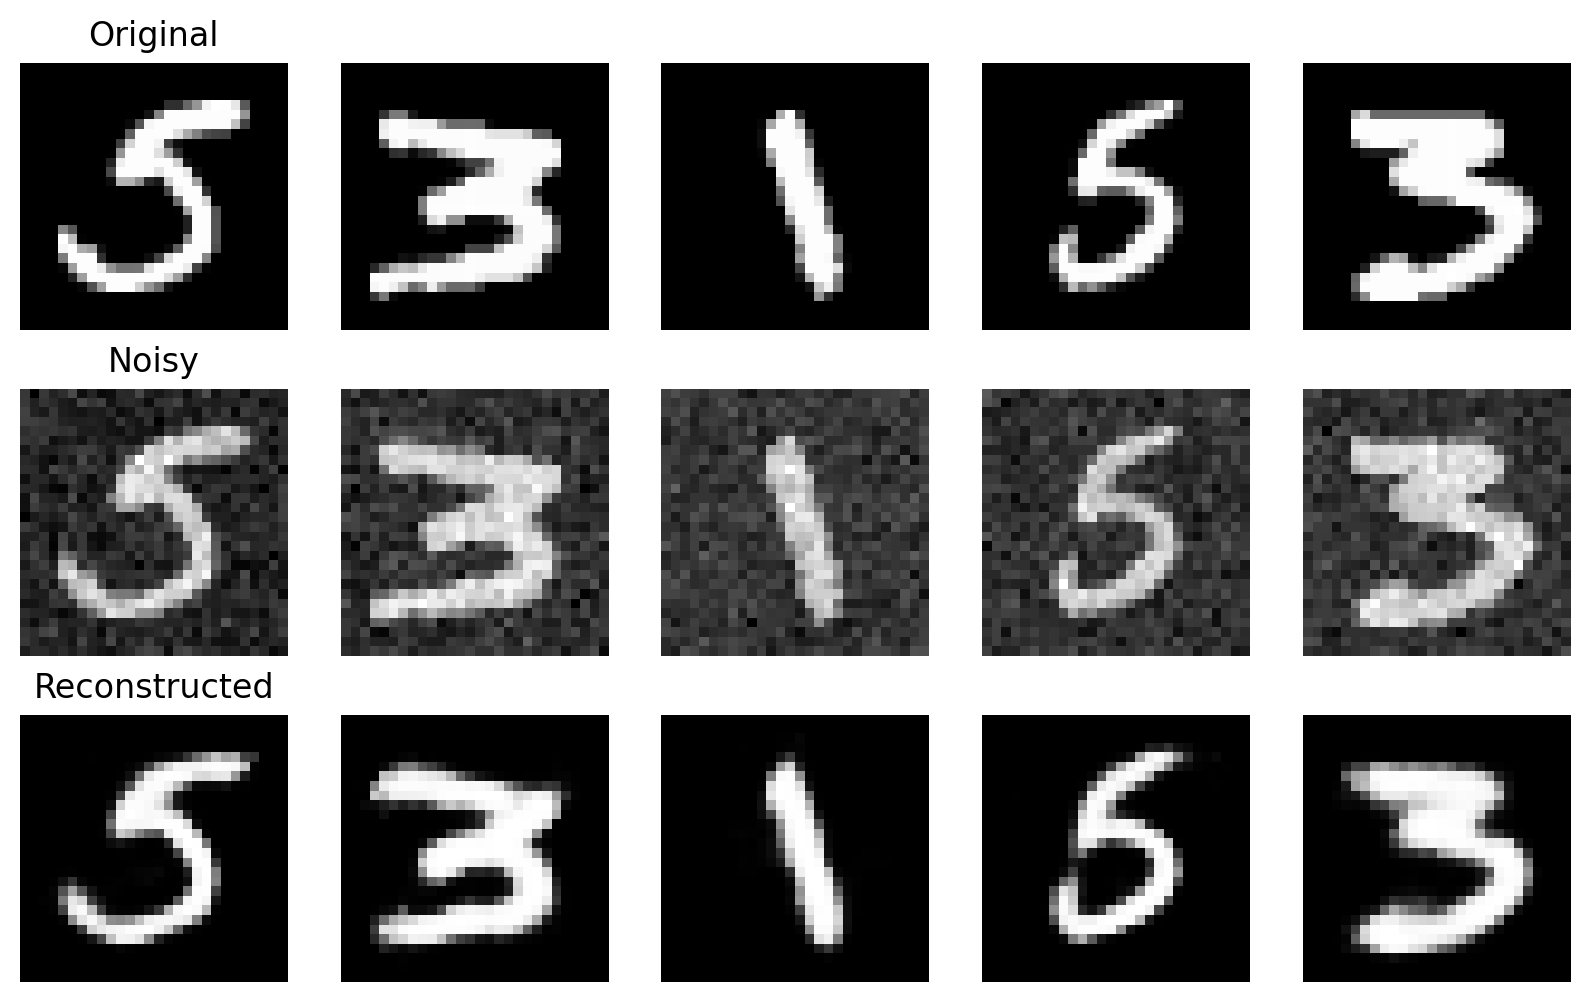

Epoch 0.
--- MSE --- 
Training loss: 0.1177. Validation loss: 0.0638
--- PSNR --- 
Training: 15.84 dB. Validation: 17.98 dB
Epoch 1.
--- MSE --- 
Training loss: 0.0575. Validation loss: 0.0457
--- PSNR --- 
Training: 18.44 dB. Validation: 19.43 dB
Epoch 2.
--- MSE --- 
Training loss: 0.0484. Validation loss: 0.0401
--- PSNR --- 
Training: 19.18 dB. Validation: 20.00 dB
Epoch 3.
--- MSE --- 
Training loss: 0.0439. Validation loss: 0.0377
--- PSNR --- 
Training: 19.60 dB. Validation: 20.26 dB
Epoch 4.
--- MSE --- 
Training loss: 0.0412. Validation loss: 0.0348
--- PSNR --- 
Training: 19.88 dB. Validation: 20.62 dB
Epoch 5.
--- MSE --- 
Training loss: 0.0392. Validation loss: 0.0333
--- PSNR --- 
Training: 20.10 dB. Validation: 20.80 dB
Epoch 6.
--- MSE --- 
Training loss: 0.0375. Validation loss: 0.0320
--- PSNR --- 
Training: 20.28 dB. Validation: 20.98 dB
Epoch 7.
--- MSE --- 
Training loss: 0.0363. Validation loss: 0.0301
--- PSNR --- 
Training: 20.42 dB. Validation: 21.24 dB
Epoch 8.

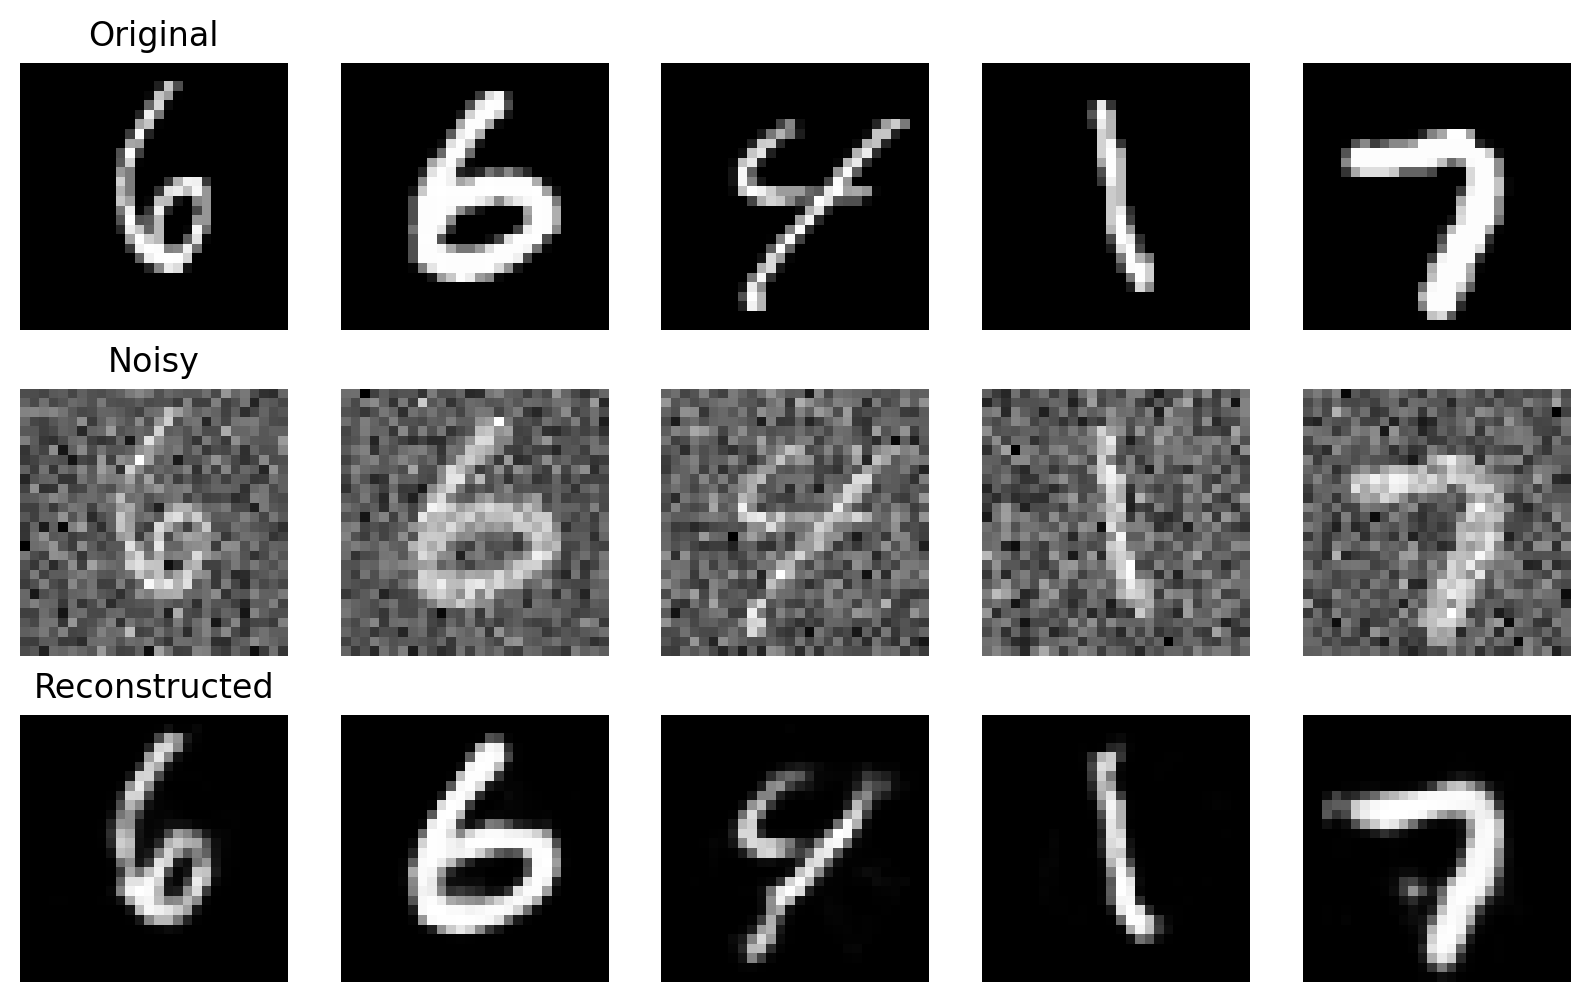

In [96]:
noise = [0.2, 0.5]
psnr_results = []
mse_results = []
for n in noise:
    autoencoder_denoising =  AutoencoderExtendedDenoising(dimx=784, hidden_dims=[512, 128], projected=100, epochs=20, lr=1e-3, noise=float(n))
    autoencoder_denoising.trainloop(trainloader, validloader)
    autoencoder_denoising.visualize_reconstructions(testloader)
    
    # Store performance 
    psnr_results.append(autoencoder_denoising.performance_during_validation[-1])
    mse_results.append(autoencoder_denoising.valid_loss_during_training[-1])


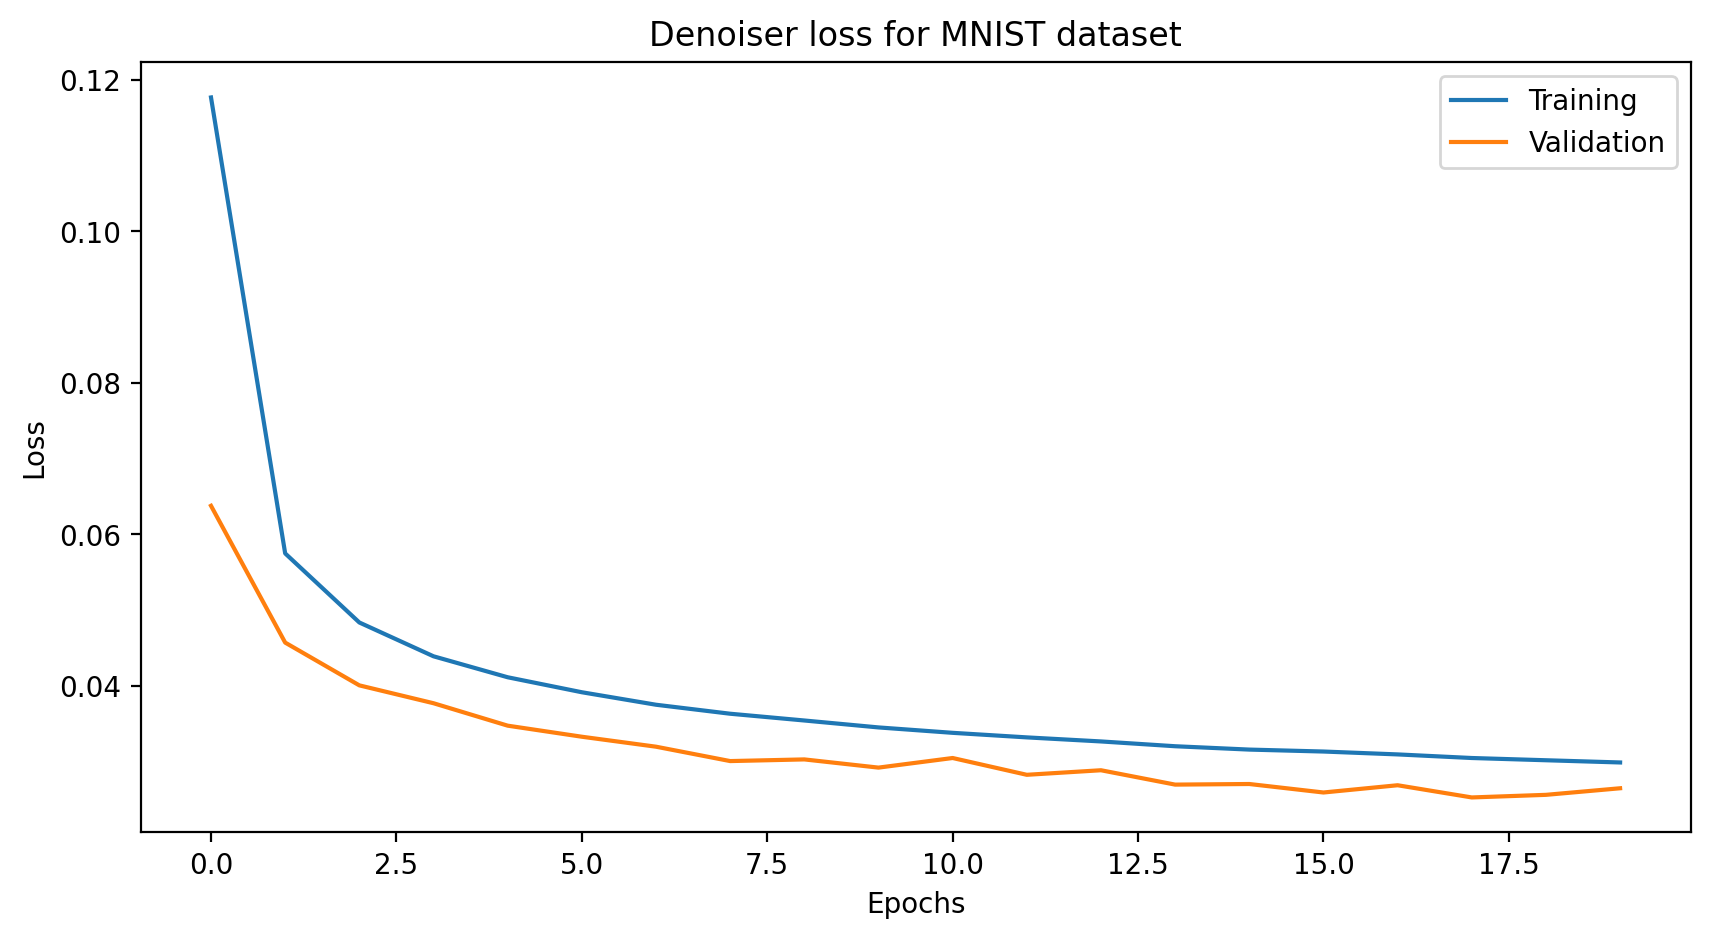

In [97]:
# MSE performance along epochs
plt.figure(figsize=(10,5))
plt.plot(autoencoder_denoising.loss_during_training, label='Training')
plt.plot(autoencoder_denoising.valid_loss_during_training, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Denoiser loss for MNIST dataset')
plt.show()

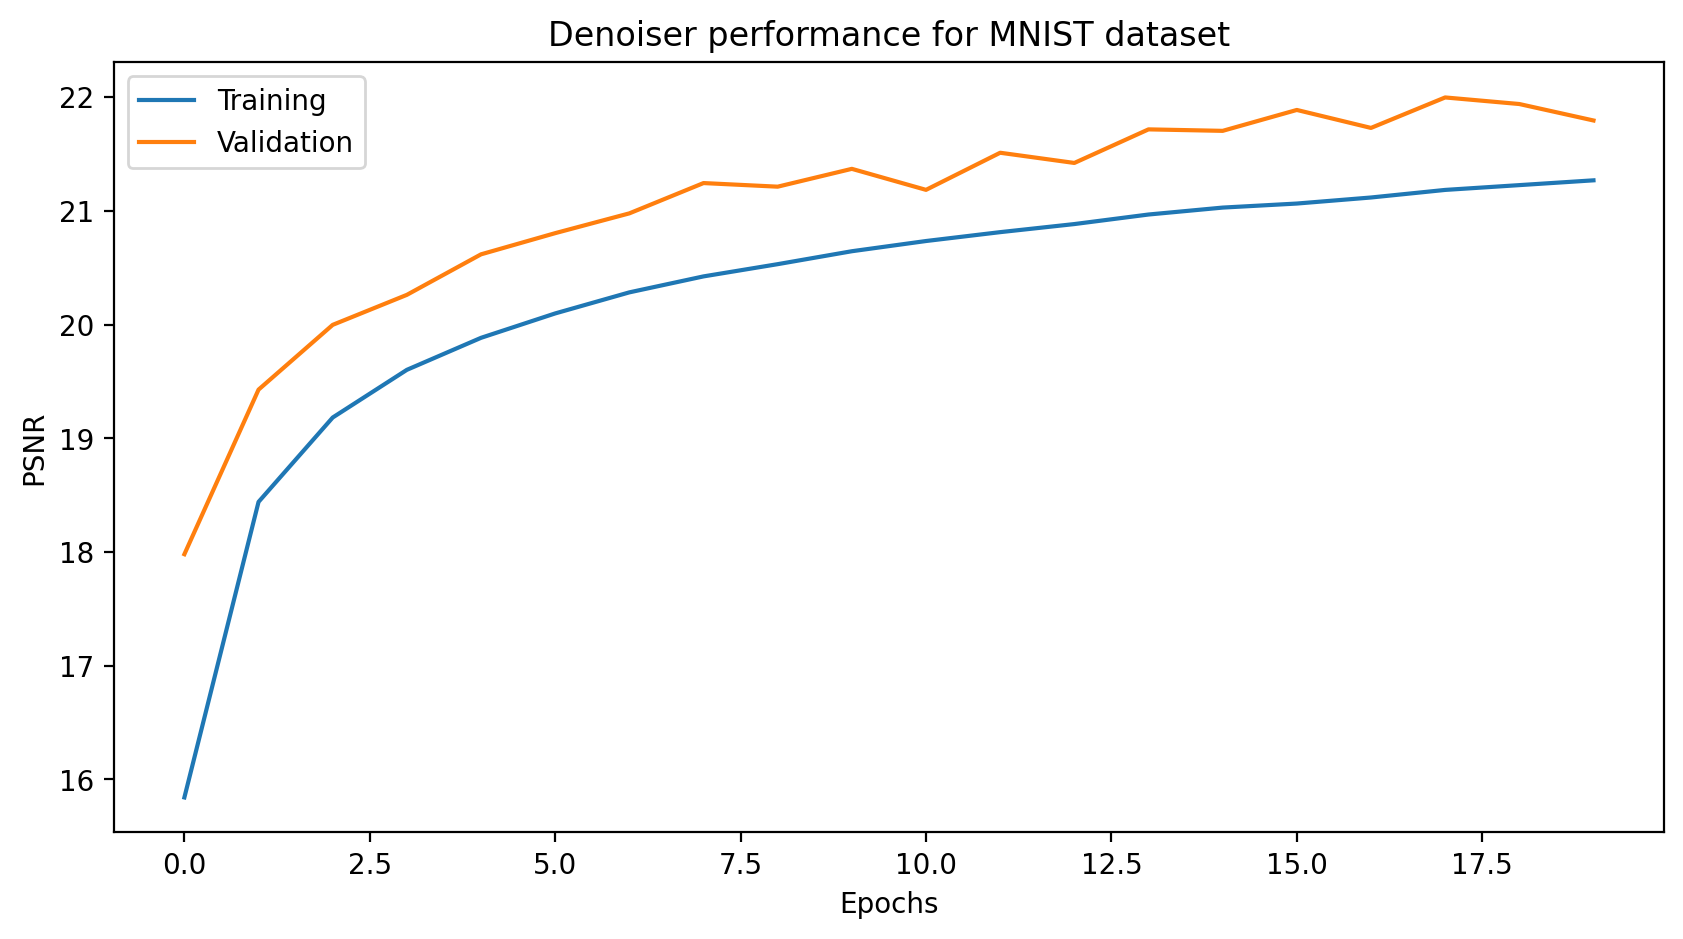

In [98]:
# PSNR performance along epochs
plt.figure(figsize=(10,5))
plt.plot(autoencoder_denoising.performance_during_training, label='Training')
plt.plot(autoencoder_denoising.performance_during_validation, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('Denoiser performance for MNIST dataset')
plt.show()

#### **For the FMNIST dataset**

In [99]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

validloader = copy.deepcopy(trainloader)

trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

Epoch 0.
--- MSE --- 
Training loss: 0.0939. Validation loss: 0.0625
--- PSNR --- 
Training: 16.71 dB. Validation: 18.07 dB
Epoch 1.
--- MSE --- 
Training loss: 0.0553. Validation loss: 0.0503
--- PSNR --- 
Training: 18.61 dB. Validation: 19.02 dB
Epoch 2.
--- MSE --- 
Training loss: 0.0475. Validation loss: 0.0450
--- PSNR --- 
Training: 19.27 dB. Validation: 19.50 dB
Epoch 3.
--- MSE --- 
Training loss: 0.0436. Validation loss: 0.0437
--- PSNR --- 
Training: 19.64 dB. Validation: 19.63 dB
Epoch 4.
--- MSE --- 
Training loss: 0.0413. Validation loss: 0.0406
--- PSNR --- 
Training: 19.88 dB. Validation: 19.96 dB
Epoch 5.
--- MSE --- 
Training loss: 0.0394. Validation loss: 0.0392
--- PSNR --- 
Training: 20.08 dB. Validation: 20.11 dB
Epoch 6.
--- MSE --- 
Training loss: 0.0382. Validation loss: 0.0376
--- PSNR --- 
Training: 20.22 dB. Validation: 20.29 dB
Epoch 7.
--- MSE --- 
Training loss: 0.0371. Validation loss: 0.0370
--- PSNR --- 
Training: 20.34 dB. Validation: 20.36 dB
Epoch 8.

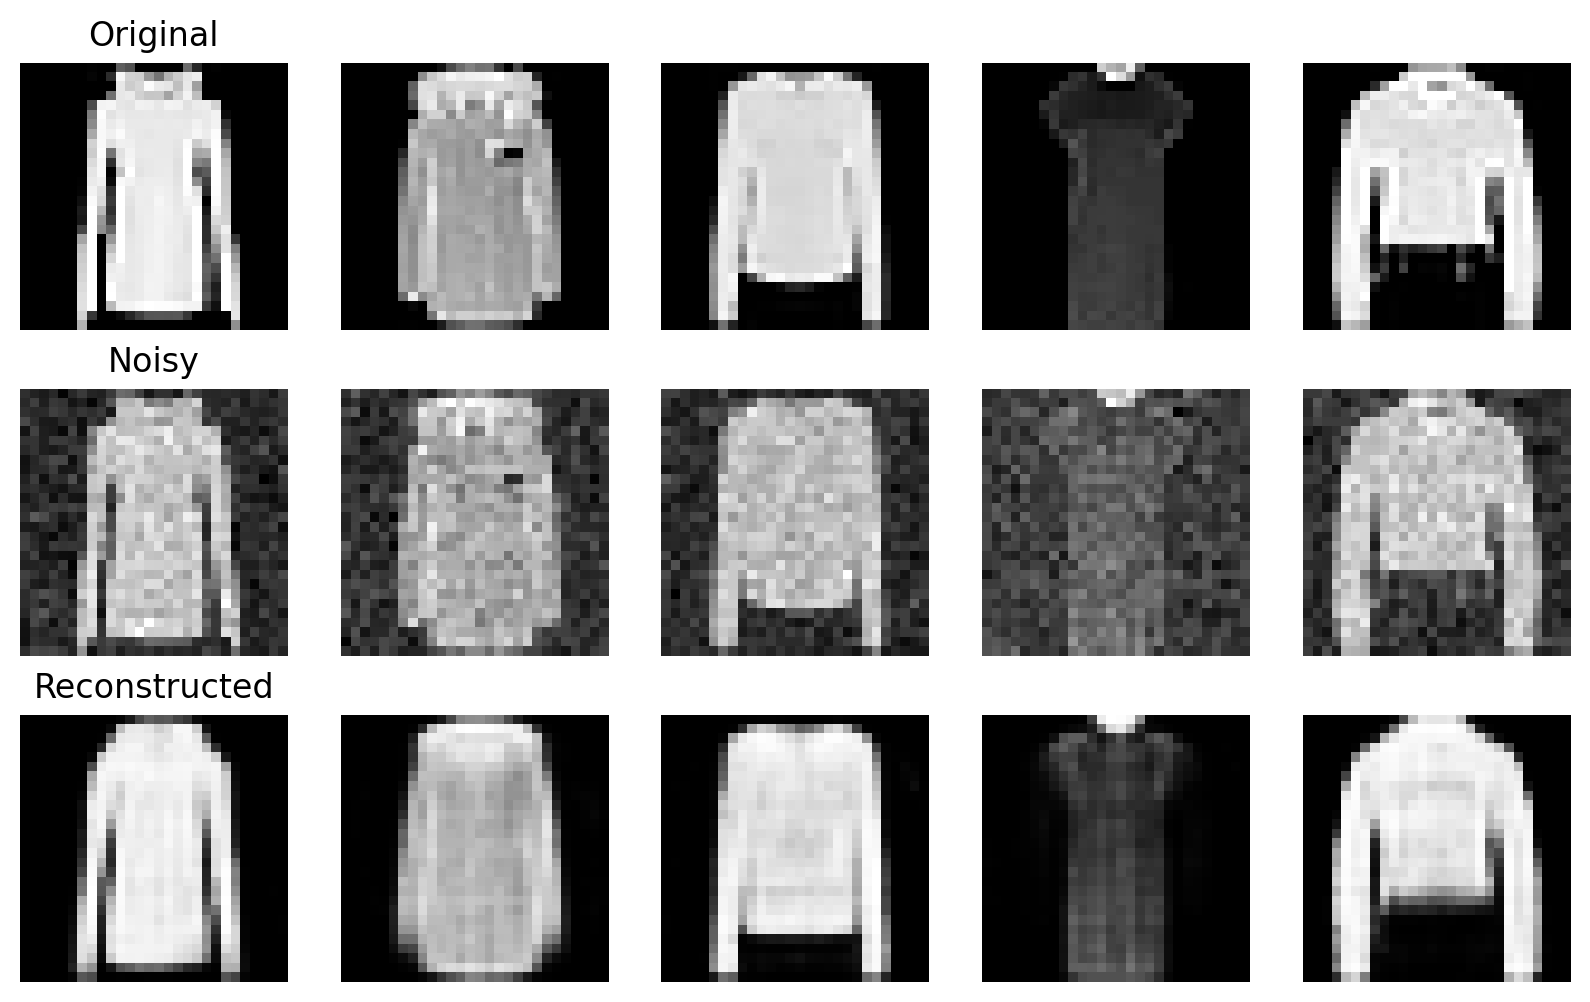

Epoch 0.
--- MSE --- 
Training loss: 0.0991. Validation loss: 0.0678
--- PSNR --- 
Training: 16.42 dB. Validation: 17.72 dB
Epoch 1.
--- MSE --- 
Training loss: 0.0624. Validation loss: 0.0548
--- PSNR --- 
Training: 18.09 dB. Validation: 18.64 dB
Epoch 2.
--- MSE --- 
Training loss: 0.0552. Validation loss: 0.0498
--- PSNR --- 
Training: 18.62 dB. Validation: 19.07 dB
Epoch 3.
--- MSE --- 
Training loss: 0.0515. Validation loss: 0.0464
--- PSNR --- 
Training: 18.91 dB. Validation: 19.37 dB
Epoch 4.
--- MSE --- 
Training loss: 0.0494. Validation loss: 0.0453
--- PSNR --- 
Training: 19.10 dB. Validation: 19.48 dB
Epoch 5.
--- MSE --- 
Training loss: 0.0479. Validation loss: 0.0441
--- PSNR --- 
Training: 19.23 dB. Validation: 19.59 dB
Epoch 6.
--- MSE --- 
Training loss: 0.0467. Validation loss: 0.0432
--- PSNR --- 
Training: 19.34 dB. Validation: 19.69 dB
Epoch 7.
--- MSE --- 
Training loss: 0.0458. Validation loss: 0.0423
--- PSNR --- 
Training: 19.42 dB. Validation: 19.77 dB
Epoch 8.

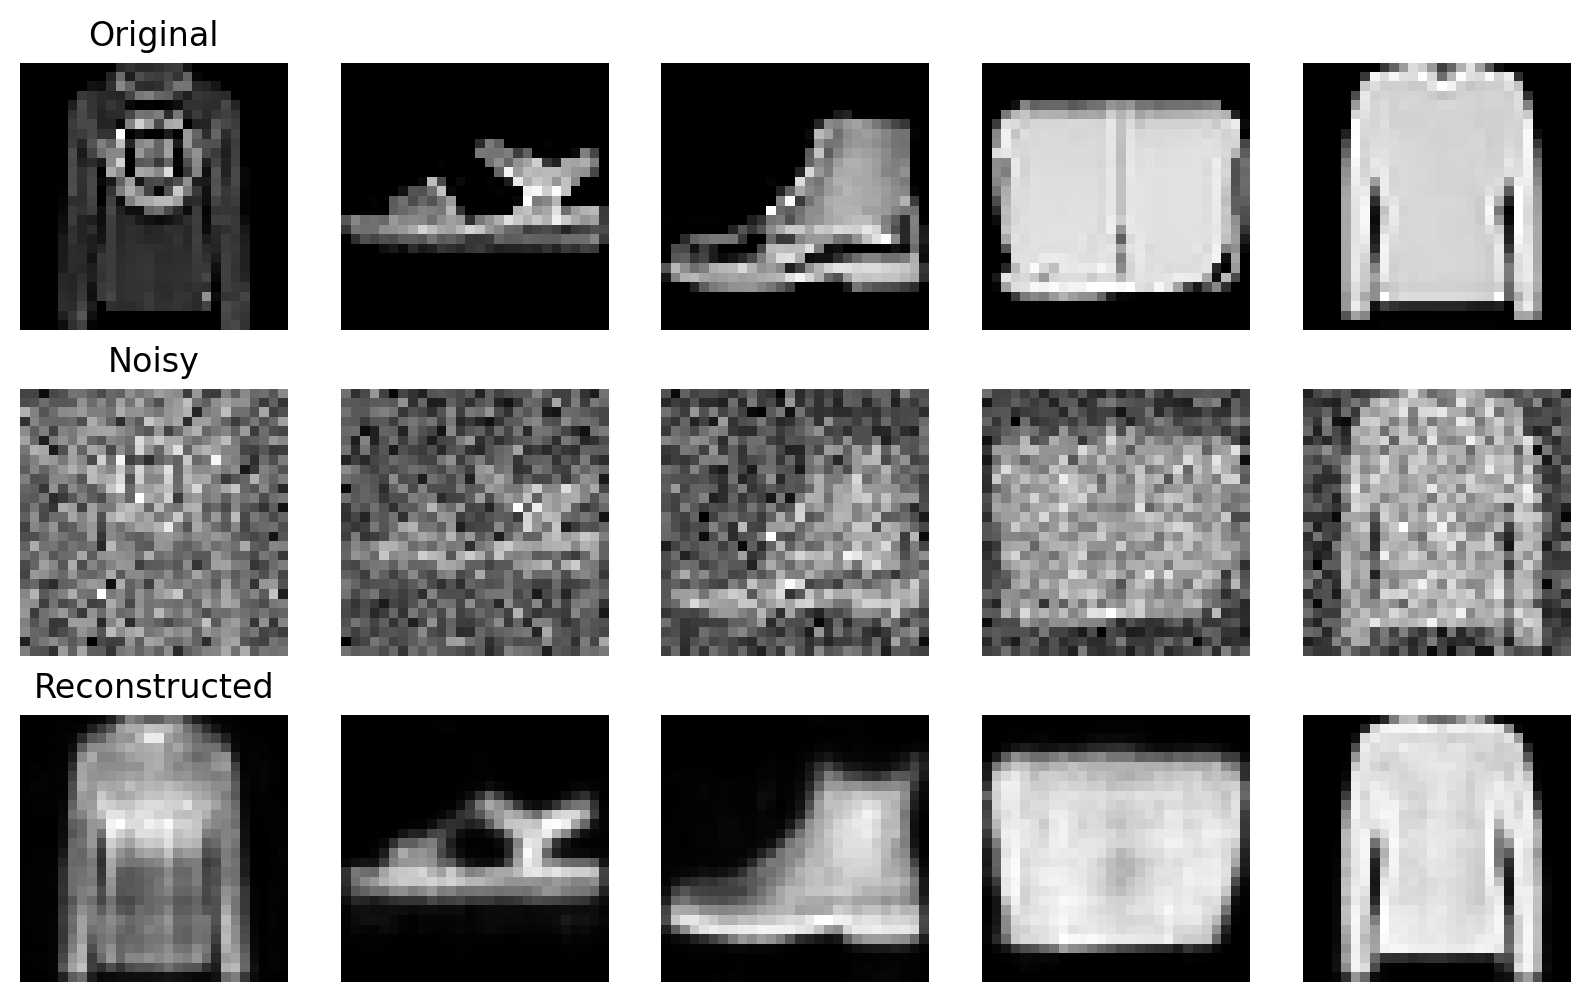

In [100]:
noise = [0.2, 0.5]

for n in noise:
    autoencoder_denoising =  AutoencoderExtendedDenoising(dimx=784, hidden_dims=[512, 256], projected=100, epochs=20, lr=1e-3, noise=float(n))
    autoencoder_denoising.trainloop(trainloader, validloader)
    autoencoder_denoising.visualize_reconstructions(testloader)


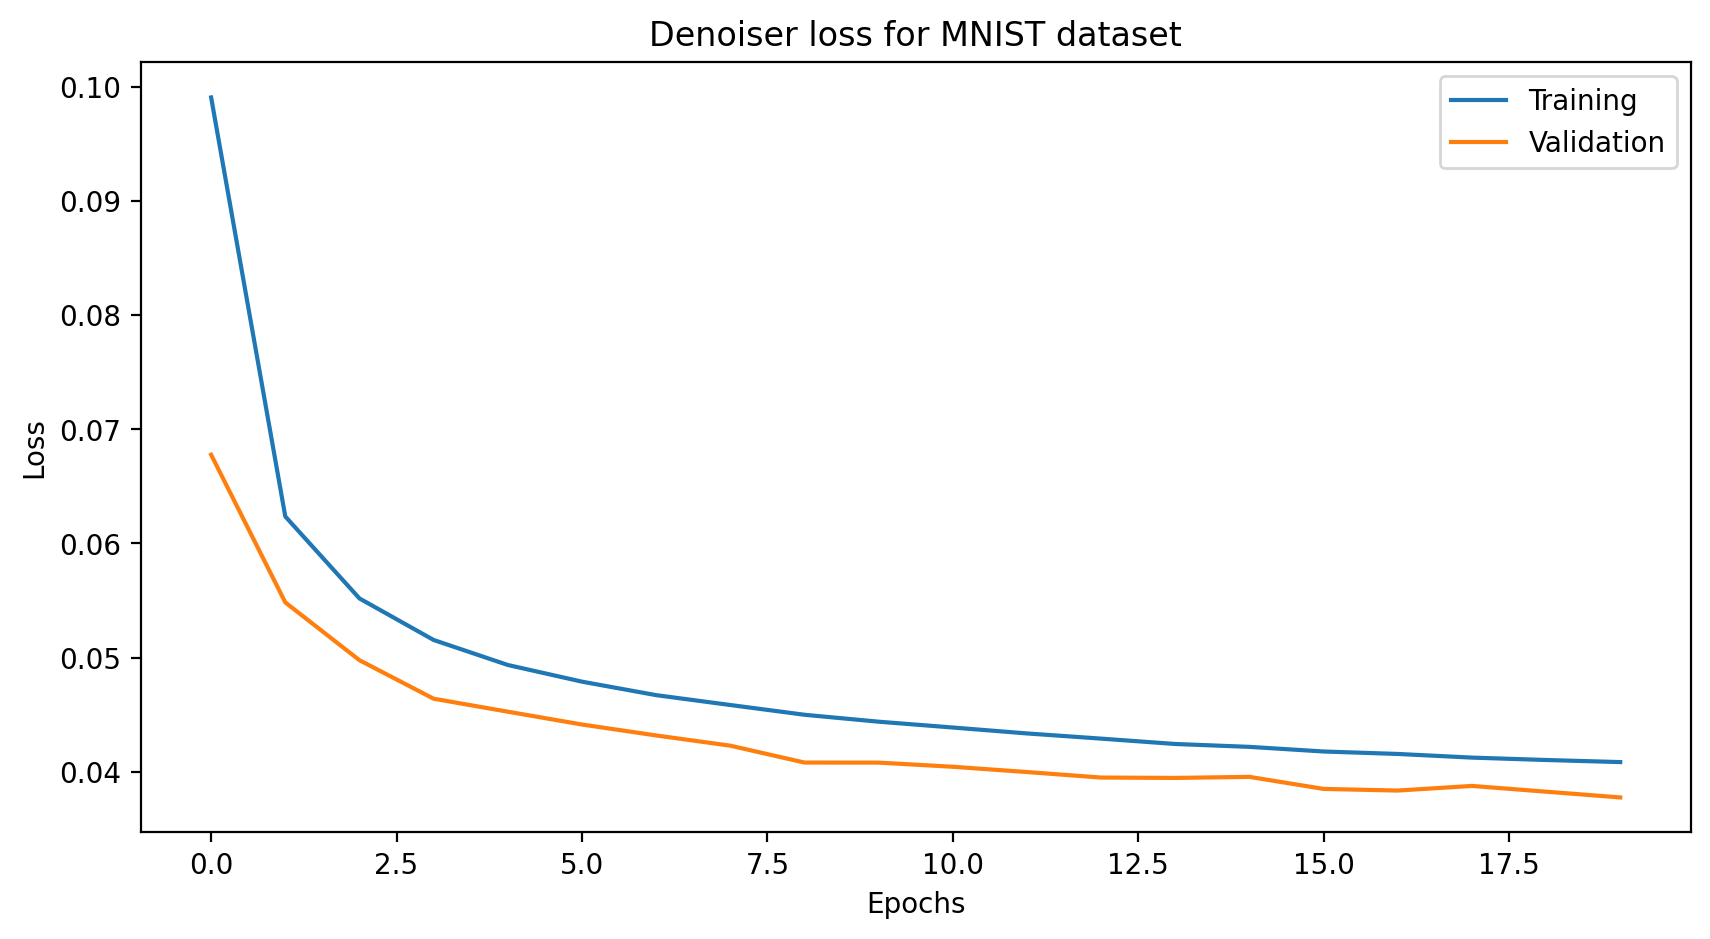

In [101]:
# MSE performance along epochs
plt.figure(figsize=(10,5))
plt.plot(autoencoder_denoising.loss_during_training, label='Training')
plt.plot(autoencoder_denoising.valid_loss_during_training, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Denoiser loss for MNIST dataset')
plt.show()

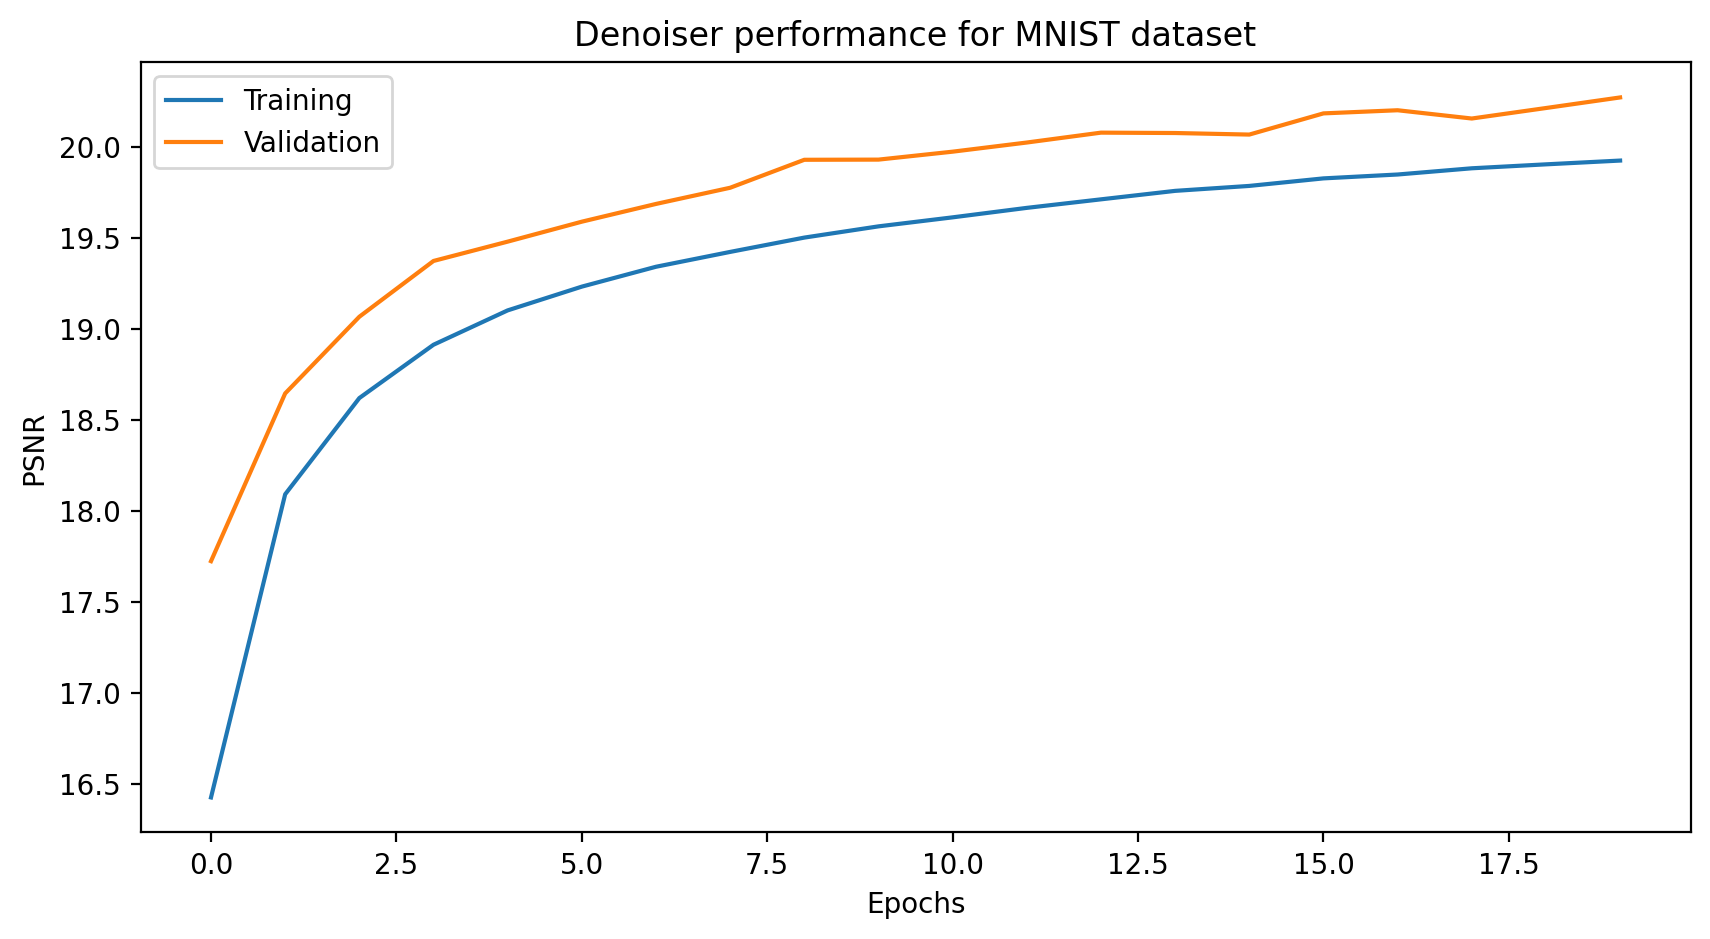

In [102]:
# PSNR performance along epochs
plt.figure(figsize=(10,5))
plt.plot(autoencoder_denoising.performance_during_training, label='Training')
plt.plot(autoencoder_denoising.performance_during_validation, label='Validation')

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('Denoiser performance for MNIST dataset')
plt.show()